# GEOSTORY PROJECT

## ELECTRONIC PUBLISHING AND DIGITAL STORYTELLING EXAM (DHDK MASTER DEGREE)

### A project by Ariele Santello, Giulia Massimino, Benedetta Togni and Szilvia Baràth


Extract the bithplace of each artHistorian, the goal is to find each respective birthplace to start the geospatial analysis

In [2]:
#Import the libraries
import rdflib
from rdflib import Namespace , Literal , URIRef
from rdflib import URIRef 
from rdflib.namespace import RDF , RDFS
import SPARQLWrapper
from SPARQLWrapper import SPARQLWrapper, JSON
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

# get wikidata endpoint API
wikidata_endpoint = "https://query.wikidata.org/bigdata/namespace/wdq/sparql"
# create an empty Graph
g = rdflib.ConjunctiveGraph()

# parse a local RDF file by specifying the format into the graph
result = g.parse("artchives.nq", format='nquads')

#create a variable for the name spaces
wd = Namespace("http://www.wikidata.org/entity/") 
wdt = Namespace("http://www.wikidata.org/prop/direct/")
art = Namespace("https://w3id.org/artchives/")

In [3]:
#create a set of all the URIs related to  arthistorians that are creators of a collection and that are entities in Wikidata 
arthistorians_list = set() 

for s,p,o in g.triples((None, wdt.P170, None)):
    if "www.wikidata.org/entity/" in str(o):
        arthistorians_list.add("<" +str(o) + ">")
        
print(arthistorians_list) 

#merging all the results in the variable arthistorians
arthistorians = ' '.join(arthistorians_list) 
print(arthistorians)


{'<http://www.wikidata.org/entity/Q60185>', '<http://www.wikidata.org/entity/Q19997512>', '<http://www.wikidata.org/entity/Q537874>', '<http://www.wikidata.org/entity/Q85761254>', '<http://www.wikidata.org/entity/Q1641821>', '<http://www.wikidata.org/entity/Q1089074>', '<http://www.wikidata.org/entity/Q1373290>', '<http://www.wikidata.org/entity/Q88907>', '<http://www.wikidata.org/entity/Q18935222>', '<http://www.wikidata.org/entity/Q3051533>', '<http://www.wikidata.org/entity/Q41616785>', '<http://www.wikidata.org/entity/Q1629748>', '<http://www.wikidata.org/entity/Q55453618>', '<http://www.wikidata.org/entity/Q61913691>', '<http://www.wikidata.org/entity/Q1271052>', '<http://www.wikidata.org/entity/Q2824734>', '<http://www.wikidata.org/entity/Q1712683>', '<http://www.wikidata.org/entity/Q6700132>', '<http://www.wikidata.org/entity/Q1715096>', '<http://www.wikidata.org/entity/Q457739>', '<http://www.wikidata.org/entity/Q1296486>', '<http://www.wikidata.org/entity/Q995470>', '<http://w

In [4]:
#Select all the URIs and labels of arthistorians and their related birthplace 
#build the query using the property (wdt:P19) 
birthplace_query = """
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
SELECT DISTINCT ?birthplace ?birthplace_label ?historian ?historian_label 
WHERE {
   VALUES ?historian {"""+arthistorians+"""} .  #include the variable in the query string
   ?historian rdfs:label ?historian_label .
   ?historian wdt:P19 ?birthplace .
   ?birthplace rdfs:label ?birthplace_label . 
   FILTER (langMatches(lang(?birthplace_label), "EN"))
   FILTER (langMatches(lang(?historian_label), "EN"))
   }
"""


# set the endpoint 
sparql_wd = SPARQLWrapper(wikidata_endpoint)
# set the query
sparql_wd.setQuery(birthplace_query)
# set the returned format
sparql_wd.setReturnFormat(JSON)
# get the results
results = sparql_wd.query().convert()

In [5]:

#loop inside the query result and retrieve the label of the art historian and its correspondent birthplace

# set the endpoint 
sparql_wd = SPARQLWrapper(wikidata_endpoint)
# set the query
sparql_wd.setQuery(birthplace_query)
# set the returned format
sparql_wd.setReturnFormat(JSON)
# get the results
results = sparql_wd.query().convert()
seen = set()
for result in results["results"]["bindings"]:
    historian_uri = result ["historian"]["value"]
    if "historian_label" in result:
        historian_label = result["historian_label"]["value"]
            #print(historian_label)
        if "birthplace" in result:
            birthplace = result["birthplace"]["value"]
        if "birthplace_label" in result:
            birthplace_label = result["birthplace_label"]["value"]
            print(historian_label, "was born in", birthplace_label)
            
        
    else:
        print("Empty dataset")
    #create the nodes to be serialized in the new graph
    g.add((URIRef(historian_uri) , URIRef(wdt.P19) , URIRef(birthplace) ))
    g.add((URIRef(birthplace) , RDFS.label , Literal(birthplace_label) ))
        

 #serialize the result in a new nq file
#new 'nq' file, where the property wdt:p19 is contained. This property is missing in artchives.nq, it was retrieved from wikidata
g.serialize(destination= 'artchives3_birthplaces.nq', format='nquads') 

Werner Cohn was born in Berlin
Werner Cohn was born in Berlin
Werner Cohn was born in Berlin
Werner Cohn was born in Berlin
Werner Cohn was born in Berlin
Werner Cohn was born in Berlin
Kurt Badt was born in Berlin
Kurt Badt was born in Berlin
Kurt Badt was born in Berlin
Werner Cohn was born in Berlin
Werner Cohn was born in Berlin
Werner Cohn was born in Berlin
Ernst Kitzinger was born in Munich
Ernst Kitzinger was born in Munich
Ernst Kitzinger was born in Munich
John Pope-Hennessy was born in London
John Pope-Hennessy was born in London
John Pope-Hennessy was born in London
Eugenio Battisti was born in Turin
Eugenio Battisti was born in Turin
Eugenio Battisti was born in Turin
Eugenio Battisti was born in Turin
Eugenio Battisti was born in Turin
Julius S. Held was born in Mosbach
Julius S. Held was born in Mosbach
Julius S. Held was born in Mosbach
Ernst Kitzinger was born in Munich
Ernst Kitzinger was born in Munich
Ernst Kitzinger was born in Munich
Ernst Kitzinger was born in Mu

In [6]:
#put data in a tabular format (csv) and clean data
import csv
import pandas as pd
import pandas_profiling as pp
import rdflib
import csv
 

# create an empty Graph
g = rdflib.ConjunctiveGraph()

# parse the file created before 
result = g.parse("artchives3_birthplaces.nq", format='nquads')  

 
#Select the label of historians and the label of their birthplaces 
qres = g.query(
  """PREFIX wdt: <http://www.wikidata.org/prop/direct/>
  SELECT DISTINCT  ?historian_label ?birthplace_label
  WHERE { 
     ?historian wdt:P19 ?birthplace ;
     rdfs:label ?historian_label.
     ?birthplace rdfs:label ?birthplace_label .
     }
    """)

#create a new file from the parsed query

with open('FG_test_birth.csv', 'wt', encoding="utf8") as out_file:
    csv_writer = csv.writer(out_file, delimiter=';')
    csv_writer.writerow(['Historian', 'Birthplace'])
    for row in qres:
        csv_writer.writerow([row.historian_label.strip(), row.birthplace_label.strip()])


In [57]:
#visualize the new csv file
import csv
import pandas as pd
import pandas_profiling as pp


df = pd.read_table("FG_test_birth.csv", delimiter =";", engine = "python", encoding = 'utf8')
df.columns = df.columns.str.replace(' ', '')

print(df.head(30))


                 Historian   Birthplace
0           Adolfo Venturi       Modena
1           Adolfo Venturi       Modena
2         Eugenio Battisti        Turin
3            Luigi Salerno         Rome
4            Luigi Salerno         Rome
5            Luigi Salerno         Rome
6            Luigi Salerno         Rome
7            Luigi Salerno         Rome
8       John Pope-Hennessy       London
9       John Pope-Hennessy       London
10      John Pope-Hennessy       London
11      John Pope-Hennessy       London
12      John Pope-Hennessy       London
13      John Pope-Hennessy       London
14  Otto Lehmann-Brockhaus         Unna
15  Otto Lehmann-Brockhaus         Unna
16  Otto Lehmann-Brockhaus         Unna
17  Otto Lehmann-Brockhaus         Unna
18  Otto Lehmann-Brockhaus         Unna
19  Otto Lehmann-Brockhaus         Unna
20         Ernst Steinmann  Jördenstorf
21         Ernst Steinmann  Jördenstorf
22         Ernst Steinmann  Jördenstorf
23         Ernst Steinmann  Jördenstorf


In [7]:
#delete the duplicates from the csv created before
import pandas as pd
file_name = "FG_test_birth.csv"
file_name_output = "birthplaces_without_dupes.csv"

df = pd.read_csv(file_name, sep=";", engine = "python", encoding = 'utf8')
df.columns = df.columns.str.replace(' ', '')

# Notes:
# - the `subset=None` means that every column is used 
#    to determine if two rows are different; to change that specify
#    the columns as an array
# - the `inplace=True` means that the data structure is changed and
#   the duplicate rows are gone  
df.drop_duplicates(subset=None, inplace=True)

# Write the results to a different file
df.to_csv(file_name_output, index=False, sep=";", encoding="utf8")

In [10]:
#print the dataframe with pandas
df = pd.read_csv("birthplaces_without_dupes.csv", delimiter=';', encoding = "utf8")
df.columns = df.columns.str.replace(' ', '')

df.drop_duplicates('Historian', keep= 'first')
df.drop_duplicates('Birthplace', keep= 'first')

df = df.drop([20], axis=0) #we delete Forl? 
df.head(30)

Historian   Birthplace
0              Werner Cohn       Berlin
1           Adolfo Venturi       Modena
2            Wolfgang Lotz    Heilbronn
3        Ulrich Middeldorf     Staßfurt
4            Federico Zeri         Rome
5            Gustav Ludwig      Nauheim
6            Luigi Salerno         Rome
7          Ernst Steinmann  Jördenstorf
8         Ellis Waterhouse        Epsom
9       John Pope-Hennessy       London
10         Kornél Fabriczy       Levoča
11             Aby Warburg      Hamburg
12     Richard Krautheimer        Fürth
13          Julius S. Held      Mosbach
14         Ernst Kitzinger       Munich
15        Eugenio Battisti        Turin
16  Otto Lehmann-Brockhaus         Unna
17               Kurt Badt       Berlin
18           Leo Steinberg       Moscow
19         Stefano Tumidei        Forlì

In [11]:
#profiling
pp.ProfileReport(df.drop_duplicates('Historian', keep= 'last'))
pp.ProfileReport(df.drop_duplicates('Birthplace', keep= 'last'))

Summarize dataset:   0%|          | 0/16 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

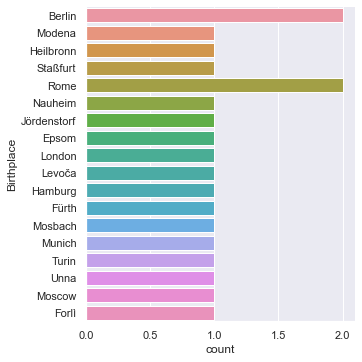

In [12]:
#plot the count
import seaborn as sns
import matplotlib.pyplot as plt

# Apply the default theme
sns.set_theme()
my_graph = sns.catplot(y="Birthplace", kind= "count", data= df) #two historians born in rome, 2 in berlin

The output count and the output csv without duplicates were used to build the birthplaces' map shown in the website

Since there are some art historians without the prop. "birthplace", not findable neither in Wikidata and Artchives, nor in ArCo or in the Dictionary of Art Historians, we searched for the prop. "citizenship" to go further in our analysis. 

In [12]:
# Search all historians that have the property CITIZENSHIP
import rdflib
from rdflib import Namespace , Literal , URIRef
from rdflib.namespace import RDF , RDFS
import csv


wd = Namespace("http://www.wikidata.org/entity/") 
wdt = Namespace("http://www.wikidata.org/prop/direct/")
art = Namespace("https://w3id.org/artchives/")



g = rdflib.ConjunctiveGraph()
world = dict()


result = g.parse("artchives.nq", format='nquads')

unique_countries = set()        #set of all art historians that have the property citizenship
for s,p,o in g.triples(( None, wdt.P27, None)):   # wikidata = P27: citizenship
    for s1,p1,o1 in g.triples(( o, RDFS.label, None)):  
        unique_countries.add(o1.strip())
for country in unique_countries:
    print(country)
    
unique_historians = set()       #set of all art historians that are creators of a collection
for s,p,o in g.triples((None, wdt.P170, None)):
    for s1,p1,o1 in g.triples((o, RDFS.label, None)): 
        unique_historians.add(o1.strip())
for historian in unique_historians:
    #print(historian)    
    
#search the label of arthistorians's(Q5) country of citizenship(P27) and count how many historians come from a specific country   
    query_result = g.query("""
    PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    PREFIX wd: <http://www.wikidata.org/entity/> 
    SELECT DISTINCT (COUNT(?individual) AS ?ind) ?country ?name      
    WHERE {
        VALUES ?class {<http://www.wikidata.org/entity/Q5>}
        VALUES ?property{<http://www.wikidata.org/prop/direct/P27>} 
        ?individual rdf:type ?class ; 
                    ?property ?country .
        ?country rdfs:label ?name
    }
    GROUP BY ?name ?country
    """)  #this query selects unique values without duplicates

with open('citizenship_count.csv', 'wt') as out_file:
    csv_writer = csv.writer(out_file, delimiter=',')
    csv_writer.writerow(['Citizenship', 'Count'])
    for row in query_result:
        csv_writer.writerow([row.name.strip(), row.ind]) 
        
import pandas as pd
data = pd.read_csv('citizenship_count.csv', encoding = 'Latin-1')
# print the first 5 rows
data.head(30)

United States of America
Italy
Hungary
England
Germany
Russia


Citizenship  Count
0                      Italy      6
1                      Italy      6
2                    Germany     12
3                    Germany     12
4                    Germany     12
5                    Germany     12
6                      Italy      6
7                    Germany     12
8                      Italy      6
9                    Germany     12
10                   Germany     12
11                   Hungary      1
12                   England      2
13                     Italy      6
14                   Germany     12
15                   Germany     12
16                   England      2
17                   Germany     12
18                   Germany     12
19                   Germany     12
20  United States of America      2
21  United States of America      2
22                     Italy      6
23                     Italy      6
24                     Italy      6
25  United States of America      2
26                     Italy      6
27                     Italy      6
28  United States of America      2
29                     Italy      6

In [13]:
import pandas_profiling as pp
pp.ProfileReport(data.drop_duplicates('Citizenship', keep= 'last'))

Summarize dataset:   0%|          | 0/16 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

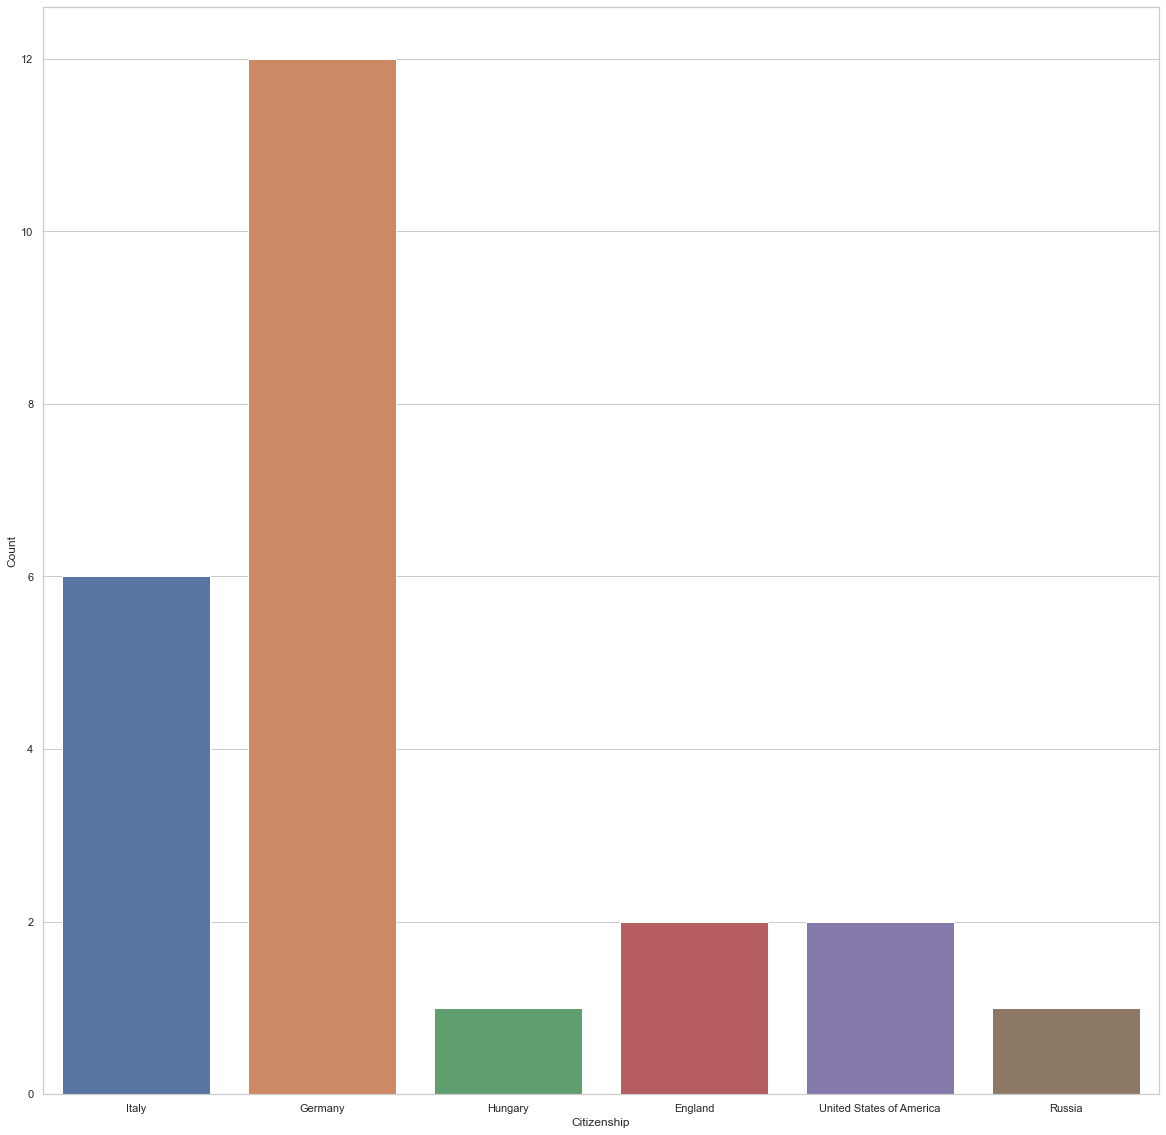

In [14]:
#plot the information found to see clearly how many historians come from each country
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
fig_dims = (20, 20)
fig, ax = plt.subplots(figsize=fig_dims)
ax = sns.barplot(x="Citizenship", y="Count", data=data) #plot the distribution:citizenships of the historians

THERE ARE: 12 HISTORIANS FROM GERMANY, 6 FROM ITALY, 1 FROM HUNGARY, 1 FROM RUSSIA, 2 FROM ENGLAND AND 2 FROM U.S.A

In [15]:
#TO VERIFY IF THE COUNT IS CORRECT


wd = Namespace("http://www.wikidata.org/entity/") 
wdt = Namespace("http://www.wikidata.org/prop/direct/")
art = Namespace("https://w3id.org/artchives/")



g = rdflib.ConjunctiveGraph()
world_2 = dict()


result = g.parse("artchives.nq", format='nquads') 

#search art historians and their country of citizenship (with related labels)
query_result_2 = g.query("""
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX wd: <http://www.wikidata.org/entity/> 
SELECT DISTINCT ?individual ?label ?country ?name 
WHERE {
    VALUES ?class {<http://www.wikidata.org/entity/Q5>}
    VALUES ?property{<http://www.wikidata.org/prop/direct/P27>}
    ?individual rdf:type ?class ;
                rdfs:label ?label;
                ?property ?country .
    ?country rdfs:label ?name .
}
GROUP BY ?individual ?label ?country ?name 
""") #perform again the query

#create a dictionary with the art historian and the related country of citizenship
for query_res in query_result_2:
    for query in query_res:
        world_2.update({str(query_res["name"]):str(query_res["label"])})
print(world_2)   

{'           Italy': 'Luisa Vertova', '     Germany': '            Ernst Steinmann', '                    Germany': 'Aby Warburg', '      Germany': '               Otto Lehmann-Brockhaus', '           United States of America': '                           Everett Fahy', 'Italy': 'Eugenio Battisti', ' Germany': '       Ernst Steinmann', '             Germany': '         Ernst Kitzinger', '  Italy': 'Federico Zeri', '                      Italy': 'Luisa Vertova', '                 Germany': 'Aby Warburg', '  Germany': 'Otto Lehmann-Brockhaus', '         Italy': 'Eugenio Battisti', 'Germany': 'Fritz Heinemann', ' Italy': 'Luisa Vertova', '                  Germany': 'Julian Kliemann', '                        Italy': 'Federico Zeri', '               Italy': 'Federico Zeri', '               Germany': 'Werner Cohn', '         Germany': 'Fritz Heinemann', '      Italy': 'Adolfo Venturi', '                United States of America': 'Everett Fahy', '                    United States of America

In [16]:
#Create a dataframe with pandas to see in a better way the information
import csv
import rdflib

with open('dict_city.csv', 'w') as out_file:
    csv_writer = csv.writer(out_file, delimiter=',')
    csv_writer.writerow(['Country', 'Historian'])
    for row in query_result_2:
        csv_writer.writerow([row.name.strip(), row.label.strip(),])
        
        
import pandas as pd
data = pd.read_csv('dict_city.csv', encoding = 'Latin-1')

data.head(30)

Country               Historian
0                      Italy           Luigi Salerno
1                    Germany  Otto Lehmann-Brockhaus
2                    Germany       Ulrich Middeldorf
3                    Germany         Ernst Kitzinger
4   United States of America          Julius S. Held
5                      Italy           Federico Zeri
6                    Germany     Richard Krautheimer
7                    Germany           Wolfgang Lotz
8                      Italy           Federico Zeri
9                      Italy          Adolfo Venturi
10                   Germany     Richard Krautheimer
11                   Germany       Ulrich Middeldorf
12                   Germany     Richard Krautheimer
13                     Italy           Federico Zeri
14                   Germany         Ernst Steinmann
15                     Italy           Federico Zeri
16                     Italy          Adolfo Venturi
17                   Germany         Ernst Steinmann
18                   Germany       Ulrich Middeldorf
19                     Italy           Federico Zeri
20                     Italy        Eugenio Battisti
21                   Germany         Ernst Steinmann
22                   Germany  Otto Lehmann-Brockhaus
23                     Italy          Adolfo Venturi
24                   Germany     Richard Krautheimer
25                   Germany             Aby Warburg
26                   Germany         Ernst Steinmann
27                   Germany         Fritz Heinemann
28                   Germany           Wolfgang Lotz
29                   Germany  Otto Lehmann-Brockhaus

In [17]:
import pandas_profiling as pp
pp.ProfileReport(data.drop_duplicates('Historian', keep= 'last'))
pp.ProfileReport(data.drop_duplicates('Country', keep= 'last')) 

Summarize dataset:   0%|          | 0/16 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [18]:
#delete the duplicates from the file dict_city created before and create a new clean file
import pandas as pd
file_name = "dict_city.csv"
file_name_output = "dict_city_without_dupes.csv"
dupes = set()
df = pd.read_csv(file_name, sep=";", engine = "python", encoding = "latin-1")
df.columns = df.columns.str.replace(' ', '')

df.drop_duplicates(subset=None, inplace=True)

# Write the results to a different file
df.to_csv(file_name_output, index=False, sep=";", encoding = "utf8")

In [50]:
import pandas as pd
df = pd.read_csv('dict_city_without_dupes.csv', encoding = 'utf8')
#open the file as a pandas dataframe

df.head(30)

Country               Historian
0                      Italy           Luigi Salerno
1                    Germany  Otto Lehmann-Brockhaus
2                    Germany       Ulrich Middeldorf
3                    Germany         Ernst Kitzinger
4   United States of America          Julius S. Held
5                      Italy           Federico Zeri
6                    Germany     Richard Krautheimer
7                    Germany           Wolfgang Lotz
8                      Italy          Adolfo Venturi
9                    Germany         Ernst Steinmann
10                     Italy        Eugenio Battisti
11                   Germany             Aby Warburg
12                   Germany         Fritz Heinemann
13                     Italy         Stefano Tumidei
14                   Germany         Julian Kliemann
15                     Italy           Luisa Vertova
16                   Germany               Kurt Badt
17                   Germany           Gustav Ludwig
18  United States of America            Everett Fahy
19                   England      John Pope-Hennessy
20                   Germany             Werner Cohn
21                   Hungary         Kornél Fabriczy
22                    Russia           Leo Steinberg
23                   England        Ellis Waterhouse

In [51]:
#style the dataframe
df.style.set_properties(**{'background-color': 'black',
                           'color': 'lawngreen',
                           'border-color': 'white'}) 

In [19]:
#use the new clean file created to create a matrix that shows the number of art historian for each country
import csv
from collections import defaultdict
import numpy as np
data = {} # final data
#we create a matrice to plot our data from dict city
with open('dict_city_without_dupes.csv', encoding="utf8") as csvfile:
    historians = [] 
    countries = []
    rows = csv.reader(csvfile, delimiter=',')
    next(rows) # skip the header
    for row in rows:
        if row[0] not in historians:
            historians.append(row[0]) # create the list of unique historians
        if row[1] not in countries:
            countries.append(row[1]) # create the list of unique countries
    print(historians)
    print(countries)
    countries.sort()
    histo_zeros_matrix = np.array(np.zeros(( len(countries), len(historians) ))) 
    
    for i, histo in enumerate(historians):  
        for j, country in enumerate(countries):
            with open('dict_city_without_dupes.csv', encoding="utf-8") as csvfile:
                rows = csv.reader(csvfile, delimiter=',')
                for row in rows:
                    if row[1] == country and row[0] == histo:
                        histo_zeros_matrix[j][i] = int(histo_zeros_matrix[j][i])+1
    
    histo_zeros_matrix
    
# put everything together
data["historians"] = historians
for i, country in enumerate(countries):
    data[country] = list(histo_zeros_matrix[i])
print(data) 

['Italy', 'Germany', 'United States of America', 'England', 'Hungary', 'Russia']
['Luigi Salerno', 'Otto Lehmann-Brockhaus', 'Ulrich Middeldorf', 'Ernst Kitzinger', 'Julius S. Held', 'Federico Zeri', 'Richard Krautheimer', 'Wolfgang Lotz', 'Adolfo Venturi', 'Ernst Steinmann', 'Eugenio Battisti', 'Aby Warburg', 'Fritz Heinemann', 'Stefano Tumidei', 'Julian Kliemann', 'Luisa Vertova', 'Kurt Badt', 'Gustav Ludwig', 'Everett Fahy', 'John Pope-Hennessy', 'Werner Cohn', 'Kornél Fabriczy', 'Leo Steinberg', 'Ellis Waterhouse']
{'historians': ['Italy', 'Germany', 'United States of America', 'England', 'Hungary', 'Russia'], 'Aby Warburg': [0.0, 1.0, 0.0, 0.0, 0.0, 0.0], 'Adolfo Venturi': [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'Ellis Waterhouse': [0.0, 0.0, 0.0, 1.0, 0.0, 0.0], 'Ernst Kitzinger': [0.0, 1.0, 0.0, 0.0, 0.0, 0.0], 'Ernst Steinmann': [0.0, 1.0, 0.0, 0.0, 0.0, 0.0], 'Eugenio Battisti': [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'Everett Fahy': [0.0, 0.0, 1.0, 0.0, 0.0, 0.0], 'Federico Zeri': [1.0, 0.0,

In [20]:
#create a BARPLOT : HISTORIANS AND THEIR COUNTRIES OF CITIZENSHIP

from bokeh.io import output_file, show, curdoc
from bokeh.models import ColumnDataSource, FactorRange
from bokeh.plotting import figure
from bokeh.transform import factor_cmap
import random

output_file("bar_nested_colormapped_historian_citizenship.html") #outputfile
curdoc().theme = 'dark_minimal' #set a dark theme

countries = ['Germany', 'Italy', 'United States of America', 'England', 'Hungary', 'Russia']
historians = ['Werner Cohn', 'Ulrich Middeldorf', 'Gustav Ludwig', 'Federico Zeri', 'Wolfgang Lotz', 'Fritz Heinemann', 'Everett Fahy', 'Adolfo Venturi', 'Luigi Salerno', 'Ernst Kitzinger', 'Richard Krautheimer', 'Kurt Badt', 'Aby Warburg', 'Otto Lehmann-Brockhaus', 'John Pope-Hennessy', 'Stefano Tumidei', 'Luisa Vertova', 'Ernst Steinmann', 'KornÃ©l Fabriczy', 'Julius S. Held', 'Leo Steinberg', 'Eugenio Battisti', 'Julian Kliemann', 'Ellis Waterhouse']

data = {'historians': ['Germany', 'Italy', 'United States of America', 'England', 'Hungary', 'Russia'], 'Aby Warburg': [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'Adolfo Venturi': [0.0, 1.0, 0.0, 0.0, 0.0, 0.0], 'Ellis Waterhouse': [0.0, 0.0, 0.0, 1.0, 0.0, 0.0], 'Ernst Kitzinger': [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'Ernst Steinmann': [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'Eugenio Battisti': [0.0, 1.0, 0.0, 0.0, 0.0, 0.0], 'Everett Fahy': [0.0, 0.0, 1.0, 0.0, 0.0, 0.0], 'Federico Zeri': [0.0, 1.0, 0.0, 0.0, 0.0, 0.0], 'Fritz Heinemann': [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'Gustav Ludwig': [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'John Pope-Hennessy': [0.0, 0.0, 0.0, 1.0, 0.0, 0.0], 'Julian Kliemann': [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'Julius S. Held': [0.0, 0.0, 1.0, 0.0, 0.0, 0.0], 'KornÃ©l Fabriczy': [0.0, 0.0, 0.0, 0.0, 1.0, 0.0], 'Kurt Badt': [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'Leo Steinberg': [0.0, 0.0, 0.0, 0.0, 0.0, 1.0], 'Luigi Salerno': [0.0, 1.0, 0.0, 0.0, 0.0, 0.0], 'Luisa Vertova': [0.0, 1.0, 0.0, 0.0, 0.0, 0.0], 'Otto Lehmann-Brockhaus': [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'Richard Krautheimer': [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'Stefano Tumidei': [0.0, 1.0, 0.0, 0.0, 0.0, 0.0], 'Ulrich Middeldorf': [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'Werner Cohn': [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'Wolfgang Lotz': [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]}
number_of_colors = 24 #number of arthistorians present in the file artchives.nq
palette = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]



x = [ (country, historian) for country in countries for historian in historians ]
counts = sum(zip(data['Werner Cohn'], data['Ulrich Middeldorf'], data['Gustav Ludwig'],
                 data['Federico Zeri'], data['Wolfgang Lotz'], data['Fritz Heinemann'], 
                 data['Everett Fahy'],data['Adolfo Venturi'],data['Luigi Salerno'],
                 data['Ernst Kitzinger'],data['Richard Krautheimer'],data['Kurt Badt'],
                 data['Aby Warburg'],data['Otto Lehmann-Brockhaus'],
                 data['John Pope-Hennessy'], data['Stefano Tumidei'], data['Luisa Vertova'], data['Ernst Steinmann'], 
                 data['KornÃ©l Fabriczy'], data['Julius S. Held'], data['Leo Steinberg'], 
                 data['Eugenio Battisti'], data['Julian Kliemann'], data['Ellis Waterhouse']), ()) 

source = ColumnDataSource(data=dict(x=x, counts=counts))

p = figure(x_range=FactorRange(*x), plot_height=650, width=1500, title="Historians' Countries of Citizenship",
           toolbar_location=None, tools="")

p.vbar(x='x', top='counts', width=0.9, source=source, line_color="white", 
       fill_color=factor_cmap('x', palette=palette, factors=historians, start=1, end=2,))

p.y_range.start = 0
p.x_range.range_padding = 0.1
p.xaxis.major_label_orientation = 1.55
p.xaxis.major_label_standoff = 25


#p.xaxis.axis_label= 'Kunsthistorisches Institut in Florenz'
p.xgrid.grid_line_color = None


show(p)
#this is a distributional barplot: the country of citizenship of each art historian 
#this is not so user friendly

In [23]:
#create a MATRIX to produce instead a PIE CHART
import csv
from collections import defaultdict
import numpy as np
data = {} # final data
with open('dict_city_without_dupes.csv') as csvfile:
    country = [] 
    rows = csv.reader(csvfile, delimiter=',')
    next(rows)
    for row in rows:
        if row[0] not in country:
            country.append(row[0]) 
       
    print(country)
    historian_zeros_matrix = np.array(np.zeros((len(country) ))) # rows, columns
    
    for i, con in enumerate(country):  
            with open('dict_city_without_dupes.csv') as csvfile:
                rows = csv.reader(csvfile, delimiter=',')
                for row in rows:
                    if row[0] == con:  
                        historian_zeros_matrix[i] = int(historian_zeros_matrix[i])+1
    
    historian_zeros_matrix
    
#distribution matrix of the number of historians per country
print(historian_zeros_matrix)

['Italy', 'Germany', 'United States of America', 'England', 'Hungary', 'Russia']
[ 6. 12.  2.  2.  1.  1.]


In [26]:
#create a PIE CHART: total number of historians for each country
from math import pi

import pandas as pd

from bokeh.io import output_file, show, curdoc
#from bokeh.palettes import 
from bokeh.plotting import figure
from bokeh.transform import cumsum
import random

output_file("pie_citizenship.html")
curdoc().theme = 'dark_minimal'

x ={ 'Italy':6, 
    'Germany':12, 
    'United States of America':2, 
    'England':2, 
    'Hungary':1, 
    'Russia':1

 }

data = pd.Series(x).reset_index(name='value').rename(columns={'index':'Country'})
data['angle'] = data['value']/data['value'].sum() * 2*pi
number_of_colors = 6 
palette = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) #select a random choice of colors
             for i in range(number_of_colors)]
data['color'] = palette

p = figure(plot_height=700, title="Number of Historians per Countries", toolbar_location=None,
           tools="hover", tooltips="@Country: @value", x_range=(-0.5, 1.0)) #plot the legend

p.wedge(x=0, y=1, radius=0.4,
        start_angle=cumsum('angle', include_zero=True), end_angle=cumsum('angle'),
        line_color="white", fill_color='color', legend_field='Country', source=data)

p.axis.axis_label=None
p.axis.visible=False
p.grid.grid_line_color = None

show(p)
#this chart is included in the website

Put all the retrieved info together: find out which artistic periods are studied in relation to the country of citizenship of the art historian.

In [65]:
#search which artistic periods are studied in relation to the country of citizenship of the art historian
import rdflib
import csv
from rdflib import Namespace , Literal , URIRef
from rdflib.namespace import RDF , RDFS
import pprint


wd = Namespace("http://www.wikidata.org/entity/") 
wdt = Namespace("http://www.wikidata.org/prop/direct/")
art = Namespace("https://w3id.org/artchives/")



g = rdflib.ConjunctiveGraph()


result = g.parse("artchives.nq", format='nquads')

#search the label of artistic periods studied by an historian and the label of the country of the historian
query_keepers = g.query('''
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX wdp: <http://www.wikidata.org/wiki/Property:>
PREFIX art: <https://w3id.org/artchives/>
PREFIX wd: <http://www.wikidata.org/entity/>
SELECT DISTINCT ?nameCountry ?periodLabel
WHERE {
  ?coll wdt:P170 ?historian ;
      art:hasSubjectPeriod ?period .
  ?historian a wd:Q5;
     wdt:P27 ?paese.
 ?paese rdfs:label ?nameCountry .
 ?period rdfs:label ?periodLabel . 
}
GROUP BY ?nameCountry ?periodLabel

''') 
#the property P27 indicates the country from which the art historian comes 

with open('countries_hist.csv', 'wt') as out_file:
    csv_writer = csv.writer(out_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_ALL)
    csv_writer.writerow(["nameCountry", "periodLabel"])
    # access the rows of the query results
    for nameCountry, periodLabel in query_keepers:
        # write in the csv
        csv_writer.writerow([nameCountry.strip(), periodLabel.lower().strip()])        

        
import pandas as pd
data = pd.read_csv('countries_hist.csv', encoding = 'Latin-1')

data.head(20)




nameCountry    periodLabel
0        Italy    romanticism
1        Italy    romanticism
2        Italy    romanticism
3        Italy    romanticism
4        Italy    romanticism
5        Italy    romanticism
6        Italy    romanticism
7        Italy    romanticism
8        Italy    romanticism
9        Italy    romanticism
10       Italy    romanticism
11       Italy  neoclassicism
12       Italy  neoclassicism
13       Italy  neoclassicism
14       Italy  neoclassicism
15       Italy  neoclassicism
16       Italy  neoclassicism
17       Italy  neoclassicism
18       Italy  neoclassicism
19       Italy  neoclassicism

In [66]:
#open the dataframe with pandas
import csv
import pandas as pd


with open("countries_hist.csv") as csv_file:
    df = pd.read_csv(csv_file, delimiter=',', encoding = "latin-1")
print(df.head(30))

   nameCountry    periodLabel
0        Italy    romanticism
1        Italy    romanticism
2        Italy    romanticism
3        Italy    romanticism
4        Italy    romanticism
5        Italy    romanticism
6        Italy    romanticism
7        Italy    romanticism
8        Italy    romanticism
9        Italy    romanticism
10       Italy    romanticism
11       Italy  neoclassicism
12       Italy  neoclassicism
13       Italy  neoclassicism
14       Italy  neoclassicism
15       Italy  neoclassicism
16       Italy  neoclassicism
17       Italy  neoclassicism
18       Italy  neoclassicism
19       Italy  neoclassicism
20       Italy  neoclassicism
21       Italy  neoclassicism
22       Italy  neoclassicism
23       Italy  neoclassicism
24       Italy  neoclassicism
25       Italy  neoclassicism
26       Italy  neoclassicism
27       Italy  neoclassicism
28       Italy  neoclassicism
29       Italy  neoclassicism


In [67]:
#delete duplicates from the file created before
import pandas as pd
file_name = "countries_hist.csv"
file_name_output = "countries_hist_without_dupes.csv"

df = pd.read_csv(file_name, sep=",", engine = "python", encoding = 'latin-1')
df.columns = df.columns.str.replace(' ', '')


df.drop_duplicates(subset=None, inplace=True)

# Write the results to a different file
df.to_csv(file_name_output, index=False, sep=",", encoding="utf8")
df = pd.read_csv("countries_hist_without_dupes.csv", delimiter=',', encoding = "latin-1")
df.columns = df.columns.str.replace(' ', '')
   
df.drop_duplicates('nameCountry', keep= 'last')
df.drop_duplicates('periodLabel', keep= 'last')


df.head(40)

nameCountry                           periodLabel
0                      Italy                           romanticism
1                      Italy                         neoclassicism
2                      Italy                          19th century
3                      Italy                          17th century
4                      Italy                          16th century
5                      Italy                          15th century
6                      Italy                           renaissance
7                      Italy                          18th century
8                    Germany                          17th century
9                    Germany                          16th century
10                   Germany                               baroque
11                   Germany                          15th century
12                   Germany                           renaissance
13                   Germany                             mannerism
14  United States of America                          16th century
15  United States of America                          17th century
16  United States of America                          14th century
17  United States of America                          15th century
18  United States of America                           renaissance
19                   Germany                           middle ages
20                   England                          15th century
21                   England                           renaissance
22                   Germany                         byzantine art
23                   Germany  early christian art and architecture
24                     Italy                               baroque
25                   Germany                              cold war
26                    Russia                           renaissance
27                    Russia                            modern art
28                   Hungary                           renaissance
29                     Italy                           middle ages
30                     Italy                             mannerism
31                   England                               baroque
32                   England                             mannerism

In [68]:
import pandas_profiling as pp
pp.ProfileReport(df.drop_duplicates('nameCountry', keep= 'last'))

pp.ProfileReport(df.drop_duplicates('periodLabel', keep= 'last'))

Summarize dataset:   0%|          | 0/16 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'Italy'),
  Text(1, 0, 'Germany'),
  Text(2, 0, 'United States of America'),
  Text(3, 0, 'England'),
  Text(4, 0, 'Russia'),
  Text(5, 0, 'Hungary')])

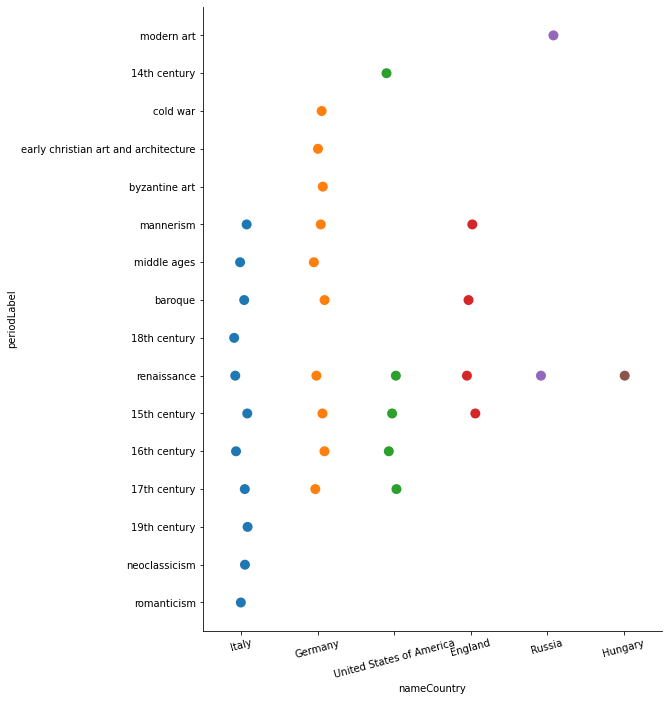

In [69]:
#create a catplot
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.catplot(x="nameCountry", y="periodLabel", sizes=(100, 100),data=df, height=9.2)
plt.xticks(rotation=15)


In [70]:
#create a matrix with periods and related countries
import csv
from collections import defaultdict
import numpy as np
data = {} # final data
with open('countries_hist_without_dupes.csv') as csvfile:
    data_periods = [] 
    countries = []
    rows = csv.reader(csvfile, delimiter=',')
    next(rows) # skip the header
    for row in rows:
        if row[0] not in data_periods:
            data_periods.append(row[0]) 
        if row[1] not in countries:
            countries.append(row[1]) 
    print(data_periods)
    print(countries)
    countries.sort()
    periods_years_zeros_matrix = np.array(np.zeros(( len(countries), len(data_periods) ))) # rows, columns
    
    for i, period in enumerate(data_periods): # loop over periods and their index position  
        for j, country in enumerate(countries):
            with open('countries_hist_without_dupes.csv') as csvfile:
                rows = csv.reader(csvfile, delimiter=',')
                for row in rows:
                    if row[1] == country and row[0] == period: 
                        periods_years_zeros_matrix[j][i] = int(periods_years_zeros_matrix[j][i])+1
    
    periods_years_zeros_matrix
    
# put everything together
data["periods"] = data_periods
for i, country in enumerate(countries):
    data[country] = list(periods_years_zeros_matrix[i])
print(data)

['Italy', 'Germany', 'United States of America', 'England', 'Russia', 'Hungary']
['romanticism', 'neoclassicism', '19th century', '17th century', '16th century', '15th century', 'renaissance', '18th century', 'baroque', 'mannerism', '14th century', 'middle ages', 'byzantine art', 'early christian art and architecture', 'cold war', 'modern art']
{'periods': ['Italy', 'Germany', 'United States of America', 'England', 'Russia', 'Hungary'], '14th century': [0.0, 0.0, 1.0, 0.0, 0.0, 0.0], '15th century': [1.0, 1.0, 1.0, 1.0, 0.0, 0.0], '16th century': [1.0, 1.0, 1.0, 0.0, 0.0, 0.0], '17th century': [1.0, 1.0, 1.0, 0.0, 0.0, 0.0], '18th century': [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], '19th century': [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'baroque': [1.0, 1.0, 0.0, 1.0, 0.0, 0.0], 'byzantine art': [0.0, 1.0, 0.0, 0.0, 0.0, 0.0], 'cold war': [0.0, 1.0, 0.0, 0.0, 0.0, 0.0], 'early christian art and architecture': [0.0, 1.0, 0.0, 0.0, 0.0, 0.0], 'mannerism': [1.0, 1.0, 0.0, 1.0, 0.0, 0.0], 'middle ages': [1.

In [81]:
#horizontal barchart viz
from bokeh.io import output_file, show
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure
from bokeh.transform import dodge
import random

output_file("bar_period_studied_in_countries.html")

number_of_colors = 16 # pick random colors for the countries
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]

p = figure(x_range=data_periods, plot_height=650, title="Periods per Historians grouped by Citizenships",
           toolbar_location=None, tools="hover", tooltips="$name: @$name", width=900)

p.vbar_stack(countries, x='periods', width=0.8, source=data, legend_label=countries, color=color) 


p.x_range.range_padding = 0.1
p.y_range.range_padding = 0.1
p.xgrid.grid_line_color = None
p.legend.location = "top_right"
p.legend.orientation = "vertical"

show(p)
#included in the website

From the last viz, it appears that even though there are 12 German art Historians, the majority of artistic periods were curated by Italian historians (that are only 6). 

The citizenship is not a fundamental factor related to the choice of studying or finding material on a certain artistic period. So we see instead the geographical distribution of the keepers (institutes) in which the collections are stored. 

In [52]:
#search for cities and countries of the keepers
import rdflib
import csv
from rdflib import Namespace , Literal , URIRef
from rdflib.namespace import RDF , RDFS
import pprint


wd = Namespace("http://www.wikidata.org/entity/") 
wdt = Namespace("http://www.wikidata.org/prop/direct/")
art = Namespace("https://w3id.org/artchives/")


g = rdflib.ConjunctiveGraph()


result = g.parse("artchives.nq", format='nquads')

#search the label of: the keepers(institutes), their country and the city in which they are located
query_keepers = g.query('''
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX wdp: <http://www.wikidata.org/wiki/Property:>
PREFIX art: <https://w3id.org/artchives/>
PREFIX wd: <http://www.wikidata.org/entity/>
SELECT DISTINCT  ?nameKeeper ?nameCountry ?nameCity
WHERE {
 ?keeper a wd:Q31855 ; 
         rdfs:label ?nameKeeper ;
         wdt:P131 ?city;
         wdt:P17 ?country .
 ?country rdfs:label ?nameCountry .
 ?city rdfs:label ?nameCity .
}
GROUP BY  ?nameKeeper ?nameCountry ?nameCity
''') 

with open('keepers_city_b.csv', 'wt') as out_file:
    csv_writer = csv.writer(out_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_ALL)
    csv_writer.writerow(["nameKeeper","nameCountry", "nameCity"])
    # access the rows of the query results
    for nameKeeper, nameCountry, nameCity in query_keepers:
        # write in the csv
        csv_writer.writerow([nameKeeper.strip(), nameCountry.strip(), nameCity.strip()])        

        
import pandas as pd
data = pd.read_csv('keepers_city_b.csv', encoding = 'Latin-1')

data.head(20)

nameKeeper               nameCountry     nameCity
0   Getty Research Institute  United States of America  Los Angeles
1   Getty Research Institute  United States of America  Los Angeles
2   Getty Research Institute  United States of America  Los Angeles
3   Getty Research Institute  United States of America  Los Angeles
4   Getty Research Institute  United States of America  Los Angeles
5   Getty Research Institute  United States of America  Los Angeles
6   Getty Research Institute  United States of America  Los Angeles
7   Getty Research Institute  United States of America  Los Angeles
8   Getty Research Institute  United States of America  Los Angeles
9   Getty Research Institute  United States of America  Los Angeles
10  Getty Research Institute  United States of America  Los Angeles
11  Getty Research Institute  United States of America  Los Angeles
12  Getty Research Institute  United States of America  Los Angeles
13  Getty Research Institute  United States of America  Los Angeles
14  Getty Research Institute  United States of America  Los Angeles
15  Getty Research Institute  United States of America  Los Angeles
16  Getty Research Institute  United States of America  Los Angeles
17  Getty Research Institute  United States of America  Los Angeles
18  Getty Research Institute  United States of America  Los Angeles
19  Getty Research Institute  United States of America  Los Angeles

In [53]:
#delete duplicates from the file created before and create a new clean file
import pandas as pd
file_name = "keepers_city_b.csv"
file_name_output = "kep_cit_new_without_dupes.csv" #create file without duplicates

df = pd.read_csv(file_name, sep=",", engine = "python", encoding = 'latin-1')
df.columns = df.columns.str.replace(' ', '')

df.drop_duplicates(subset=None, inplace=True)

# Write the results to a different file
df.to_csv(file_name_output, index=False, sep=",", encoding="utf8")

In [55]:

df = pd.read_csv("kep_cit_new_without_dupes.csv", delimiter=',', encoding = "utf8")
df.columns = df.columns.str.replace(' ', '')


df = df.drop([1], axis=0) #there are wrong data: the kunsthistorisches institute is in Italy, not in Germany, 
                          #so we delete the wrong row from the file

df.head(40)

nameKeeper  \
0                           Getty Research Institute   
2              Kunsthistorisches Institut in Florenz   
3  Bibliotheca Hertziana %u2013 Max Planck Instit...   
4                           Fondazione Federico Zeri   
5                           Scuola Normale Superiore   

                nameCountry     nameCity  
0  United States of America  Los Angeles  
2                     Italy     Florence  
3                     Italy         Rome  
4                     Italy      Bologna  
5                     Italy         Pisa

In [56]:
#style the dataframe
df.style.set_properties(**{'background-color': 'black',
                           'color': 'lawngreen',
                           'border-color': 'white'}) 
 

Bologna, Rome, Pisa, Los Angeles and lorence are the cities in which the institutes are located! The information in this df are used to buil the map shown in the website.

In [62]:
#delete the duplicates from the file and create a new file without the name of the cities, but only the countries of the keepers
#we need it to plot a distributional chart
import pandas as pd
file_name = "kep_cit_new_without_dupes.csv"
file_name_output = "countries_with_keepers_final.csv"

df = pd.read_csv(file_name, sep=",", engine = "python", encoding = 'latin-1')
df.columns = df.columns.str.replace(' ', '')

df = df.drop("nameCity", axis=1) #drop the cities to count the countries
df = df.drop([1], axis=0)

df.drop_duplicates(subset=None, inplace=True)

# Write the results to a different file
df.to_csv(file_name_output, index=False, sep=",", encoding="utf8") 

In [63]:
#open a dataframe with pandas of the new file containing only the label of keepers and their country
df = pd.read_csv("countries_with_keepers_final.csv", delimiter=',', encoding = "latin-1")
df.columns = df.columns.str.replace(' ', '')
df.head(40)

nameKeeper               nameCountry
0                           Getty Research Institute  United States of America
1              Kunsthistorisches Institut in Florenz                     Italy
2  Bibliotheca Hertziana %u2013 Max Planck Instit...                     Italy
3                           Fondazione Federico Zeri                     Italy
4                           Scuola Normale Superiore                     Italy

In [64]:
#profile the countries of the keepers
import pandas_profiling as pp
pp.ProfileReport(data.drop_duplicates('nameKeeper', keep= 'last'))

pp.ProfileReport(data.drop_duplicates('nameCountry', keep= 'last')) 

Summarize dataset:   0%|          | 0/17 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

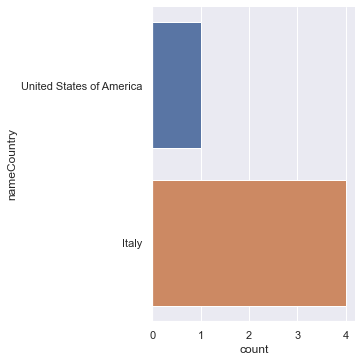

In [65]:
#plot the counting: how many keepers per country
import seaborn as sns
import matplotlib.pyplot as plt


sns.set_theme()
my_graph = sns.catplot(y="nameCountry", kind= "count", data= df)

there are 4 institutes in Italy, and one in U.S.A

In [66]:
#create a MATRIX for a PIE CHART
import csv
from collections import defaultdict
import numpy as np
data = {} # final data
with open('countries_with_keepers_final.csv') as csvfile:
    country = [] 
    rows = csv.reader(csvfile, delimiter=',')
    next(rows) 
    for row in rows:
        if row[1] not in country:
            country.append(row[1]) 
       
    print(country)
    keepers_zeros_matrix = np.array(np.zeros((len(country) ))) 
    
    for i, con in enumerate(country):  
            with open('countries_with_keepers_final.csv') as csvfile:
                rows = csv.reader(csvfile, delimiter=',')
                for row in rows:
                    if row[1] == con:  
                        keepers_zeros_matrix[i] = int(keepers_zeros_matrix[i])+1
    
    keepers_zeros_matrix
    

print(keepers_zeros_matrix)

['United States of America', 'Italy']
[1. 4.]


In [69]:
#create a PIE CHART: NUMBER OF INSTITUTES PER COUNTRIES
from math import pi
import pandas as pd
from bokeh.io import output_file, show, curdoc
from bokeh.plotting import figure
from bokeh.transform import cumsum
import random

output_file("pie.html")
curdoc().theme = 'dark_minimal'

x ={ 'Italy': 4, 
      'United States of America': 1
 }

data = pd.Series(x).reset_index(name='value').rename(columns={'index':'nameCountry'})
data['angle'] = data['value']/data['value'].sum() * 2*pi
number_of_colors = 2 
palette = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]
data['color'] = palette

p = figure(plot_height=700, title="Number of Institutes per Countries", toolbar_location=None,
           tools="hover", tooltips="@nameCountry: @value", x_range=(-0.5, 1.0))

p.wedge(x=0, y=1, radius=0.4,
        start_angle=cumsum('angle', include_zero=True), end_angle=cumsum('angle'),
        line_color="white", fill_color='color', legend_field='nameCountry', source=data)

p.axis.axis_label=None
p.axis.visible=False
p.grid.grid_line_color = None

show(p)
#this is included in the website 

Further step: we query and plot the relation between collections and historians

In [70]:
# search the historians' collections

import rdflib
from rdflib import Namespace , Literal , URIRef
from rdflib.namespace import RDF , RDFS
import csv

# bind the uncommon namespaces
wd = Namespace("http://www.wikidata.org/entity/") 
wdt = Namespace("http://www.wikidata.org/prop/direct/")
art = Namespace("https://w3id.org/artchives/")



g = rdflib.ConjunctiveGraph()



result = g.parse("artchives.nq", format='nquads')

#search the label of the collection and of the historian that have created it (P170)
    
query_result = g.query("""
    PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    PREFIX wd: <http://www.wikidata.org/entity/>
    PREFIX wdt: <http://www.wikidata.org/prop/direct/>
    PREFIX art: <https://w3id.org/artchives/>
    SELECT DISTINCT ?Collection ?Historian
    WHERE {
        ?collect wdt:P170 ?artHistorian .
        ?collect rdfs:label ?Collection .
        ?artHistorian rdfs:label ?Historian . 
    }
    GROUP BY ?Collection ?Historian
    """)

with open('coll_histor.csv', 'w') as out_file:
    csv_writer = csv.writer(out_file, delimiter=',' , quoting=csv.QUOTE_ALL)
    csv_writer.writerow(['Collection', 'Historian'])
    for Collection, Historian in query_result:
        csv_writer.writerow([Collection.strip(), Historian.strip()]) 
        
#create a dataframe with pandas        
import pandas as pd
data = pd.read_csv('coll_histor.csv', encoding = 'latin-1', error_bad_lines=False)

data.head(30)

Collection               Historian
0                       Leo Steinberg research papers           Leo Steinberg
1                       Leo Steinberg research papers           Leo Steinberg
2                                   Fondo Aby Warburg             Aby Warburg
3                          Nachlass Ulrich Middeldorf       Ulrich Middeldorf
4                          Nachlass Ulrich Middeldorf       Ulrich Middeldorf
5   Nachlass Fritz Heinemann, Notizen zur venezian...         Fritz Heinemann
6                                       Fototeca Fahy            Everett Fahy
7                                       Fototeca Fahy            Everett Fahy
8                            Fototeca Julian Kliemann         Julian Kliemann
9                            Fototeca Stefano Tumidei         Stefano Tumidei
10                               Nachlass Werner Cohn             Werner Cohn
11                    Nachlass Otto Lehmann-Brockhaus  Otto Lehmann-Brockhaus
12                    Nachlass Otto Lehmann-Brockhaus  Otto Lehmann-Brockhaus
13                    Nachlass Otto Lehmann-Brockhaus  Otto Lehmann-Brockhaus
14                              Julius S. Held papers          Julius S. Held
15                              Julius S. Held papers          Julius S. Held
16                                      Fototeca Zeri           Federico Zeri
17                                      Fototeca Zeri           Federico Zeri
18                                      Fototeca Zeri           Federico Zeri
19                                      Fototeca Zeri           Federico Zeri
20                                 Nachlass Kurt Badt               Kurt Badt
21                  Ernst Kitzinger papers, 1931-1995         Ernst Kitzinger
22                  Ernst Kitzinger papers, 1931-1995         Ernst Kitzinger
23                  Ernst Kitzinger papers, 1931-1995         Ernst Kitzinger
24                           Nachlass Ernst Steinmann         Ernst Steinmann
25                           Nachlass Ernst Steinmann         Ernst Steinmann
26                           Nachlass Ernst Steinmann         Ernst Steinmann
27                    Nachlass Cornelius von Fabriczy        KornÃ©l Fabriczy
28                      Luigi Salerno research papers           Luigi Salerno
29                             Archivio Luisa Vertova           Luisa Vertova

In [71]:
#delete the duplicates from the file created before
import pandas as pd
file_name = "coll_histor.csv"
file_name_output = "coll_histor_no_dupes.csv"

df = pd.read_csv(file_name, sep=",", engine = "python", encoding = 'latin-1')
df.columns = df.columns.str.replace(' ', '')
#we delete the duplicates from the file

df.drop_duplicates(subset=None, inplace=True)

# Write the results to a different file
df.to_csv(file_name_output, index=False, sep=",", encoding="utf8")

In [50]:
df = pd.read_csv("coll_histor_no_dupes.csv", delimiter=',', encoding = "utf8")
df.columns = df.columns.str.replace(' ', '')
  
df.drop_duplicates("Collection", keep= "last")
df.drop_duplicates("Historian", keep="last")



df.head(40)

Collection               Historian
0                        Nachlass Richard Krautheimer     Richard Krautheimer
1                   Ernst Kitzinger papers, 1931-1995         Ernst Kitzinger
2                           John Pope-Hennessy papers      John Pope-Hennessy
3                 Battisti Eugenio (complex of fonds)        Eugenio Battisti
4                          Nachlass Ulrich Middeldorf       Ulrich Middeldorf
5                              Nachlass Wolfgang Lotz           Wolfgang Lotz
6                                Nachlass Werner Cohn             Werner Cohn
7                                       Fototeca Zeri           Federico Zeri
8                                   Fondo Aby Warburg             Aby Warburg
9                       Luigi Salerno research papers           Luigi Salerno
10                    Nachlass Cornelius von Fabriczy         Kornél Fabriczy
11  Nachlass Fritz Heinemann, Notizen zur venezian...         Fritz Heinemann
12                    Nachlass Otto Lehmann-Brockhaus  Otto Lehmann-Brockhaus
13                              Julius S. Held papers          Julius S. Held
14                           Fototeca Julian Kliemann         Julian Kliemann
15                                      Fototeca Fahy            Everett Fahy
16   Ellis K. Waterhouse notebooks and research files        Ellis Waterhouse
17                           Fototeca Stefano Tumidei         Stefano Tumidei
18                           Ulrich Middledorf papers       Ulrich Middeldorf
19                             Archivio Luisa Vertova           Luisa Vertova
20                          Gustav Ludwig-Vermächtnis           Gustav Ludwig
21                      Leo Steinberg research papers           Leo Steinberg
22                  Venturi Adolfo (complex of fonds)          Adolfo Venturi
23                           Nachlass Ernst Steinmann         Ernst Steinmann
24                                 Nachlass Kurt Badt               Kurt Badt

In [72]:
#we style the dataframe: each historian has a corresponding collection, 1-to-1
df.style.set_properties(**{'background-color': 'black',
                           'color': 'lawngreen',
                           'border-color': 'white'}) 

Now search the connections between historians and the periods treated in their collections

In [64]:
#search the label of art historians and the period treated in their collection

import rdflib
from rdflib import Namespace , Literal , URIRef
from rdflib.namespace import RDF , RDFS
import csv

wd = Namespace("http://www.wikidata.org/entity/") 
wdt = Namespace("http://www.wikidata.org/prop/direct/")
art = Namespace("https://w3id.org/artchives/")



g = rdflib.ConjunctiveGraph()



result = g.parse("artchives.nq", format='nquads')


    
query_result = g.query("""
    PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    PREFIX wd: <http://www.wikidata.org/entity/>
    PREFIX wdt: <http://www.wikidata.org/prop/direct/>
    PREFIX art: <https://w3id.org/artchives/>
    SELECT DISTINCT ?Historian ?Period
    WHERE {
        ?collect rdfs:label ?Collection ;
            art:hasSubjectPeriod ?perio .
         ?collect wdt:P170 ?artHistorian .
        ?perio rdfs:label ?Period .
        ?artHistorian a wd:Q5 ;
        rdfs:label ?Historian . 
    }
    GROUP BY ?Historian ?Period
    """)

#create a csv file with the information gathered
with open('historian_periods.csv', 'wt') as out_file:
    csv_writer = csv.writer(out_file, delimiter=',' , quoting=csv.QUOTE_ALL)
    csv_writer.writerow(['Historian', 'Period'])
    for row in query_result:
        csv_writer.writerow([row.Historian.strip(), row.Period.lower().strip()])
        
        
import pandas as pd
data = pd.read_csv('historian_periods.csv', encoding = 'latin-1', error_bad_lines=False)

data.head(30)


Historian        Period
0   Kornél Fabriczy   renaissance
1   Kornél Fabriczy   renaissance
2   Kornél Fabriczy   renaissance
3   Kornél Fabriczy   renaissance
4   Kornél Fabriczy   renaissance
5   Kornél Fabriczy   renaissance
6   Kornél Fabriczy   renaissance
7   Kornél Fabriczy   renaissance
8   Kornél Fabriczy   renaissance
9   Kornél Fabriczy   renaissance
10  Kornél Fabriczy   renaissance
11    Luigi Salerno  18th century
12    Luigi Salerno  18th century
13    Luigi Salerno  18th century
14    Luigi Salerno  17th century
15    Luigi Salerno  17th century
16    Luigi Salerno  17th century
17    Luigi Salerno  17th century
18    Luigi Salerno  17th century
19    Luigi Salerno  17th century
20    Luigi Salerno  17th century
21    Luigi Salerno       baroque
22    Luigi Salerno       baroque
23    Luigi Salerno       baroque
24    Luigi Salerno       baroque
25    Luigi Salerno       baroque
26    Luigi Salerno       baroque
27    Luigi Salerno       baroque
28    Luigi Salerno       baroque
29    Luigi Salerno       baroque

In [65]:
#delete the duplicates from the file created before
import pandas as pd
file_name = "historian_periods.csv"
file_name_output = "historian_periods_without_dupes.csv"

df = pd.read_csv(file_name, sep=",", engine = "python", encoding = 'latin-1')
df.columns = df.columns.str.replace(' ', '')

  
df.drop_duplicates(subset=None, inplace=True)

# Write the results to a different file
df.to_csv(file_name_output, index=False, sep=",", encoding="utf8")

In [66]:
df = pd.read_csv("historian_periods_without_dupes.csv", delimiter=',', encoding = "latin-1")
df.columns = df.columns.str.replace(' ', '')

df.drop_duplicates('Historian', keep= 'last')
df.drop_duplicates('Period', keep= 'last')


df.head(40)

Historian                                Period
0      KornÃ©l Fabriczy                           renaissance
1         Luigi Salerno                          18th century
2         Luigi Salerno                          17th century
3         Luigi Salerno                               baroque
4       Ernst Kitzinger                           middle ages
5       Ernst Kitzinger  early christian art and architecture
6       Ernst Kitzinger                         byzantine art
7       Stefano Tumidei                         neoclassicism
8       Stefano Tumidei                               baroque
9       Stefano Tumidei                          17th century
10      Stefano Tumidei                           renaissance
11      Stefano Tumidei                          15th century
12      Stefano Tumidei                          18th century
13      Stefano Tumidei                          16th century
14            Kurt Badt                             mannerism
15            Kurt Badt                           middle ages
16            Kurt Badt                               baroque
17            Kurt Badt                          16th century
18   John Pope-Hennessy                          15th century
19   John Pope-Hennessy                           renaissance
20  Richard Krautheimer                           renaissance
21  Richard Krautheimer                         byzantine art
22  Richard Krautheimer  early christian art and architecture
23  Richard Krautheimer                               baroque
24          Aby Warburg                           renaissance
25       Julius S. Held                          17th century
26       Julius S. Held                          16th century
27          Werner Cohn                           renaissance
28          Werner Cohn                           middle ages
29        Luisa Vertova                          18th century
30        Luisa Vertova                          17th century
31        Luisa Vertova                           renaissance
32        Luisa Vertova                         neoclassicism
33        Luisa Vertova                          19th century
34        Luisa Vertova                           romanticism
35        Luisa Vertova                          15th century
36        Luisa Vertova                          16th century
37      Julian Kliemann                             mannerism
38      Julian Kliemann                               baroque
39      Julian Kliemann                          17th century

In [67]:
#profiling
import pandas_profiling as pp
pp.ProfileReport(df.drop_duplicates('Historian', keep= 'last'))
pp.ProfileReport(df.drop_duplicates('Period', keep= 'last'))

Summarize dataset:   0%|          | 0/16 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

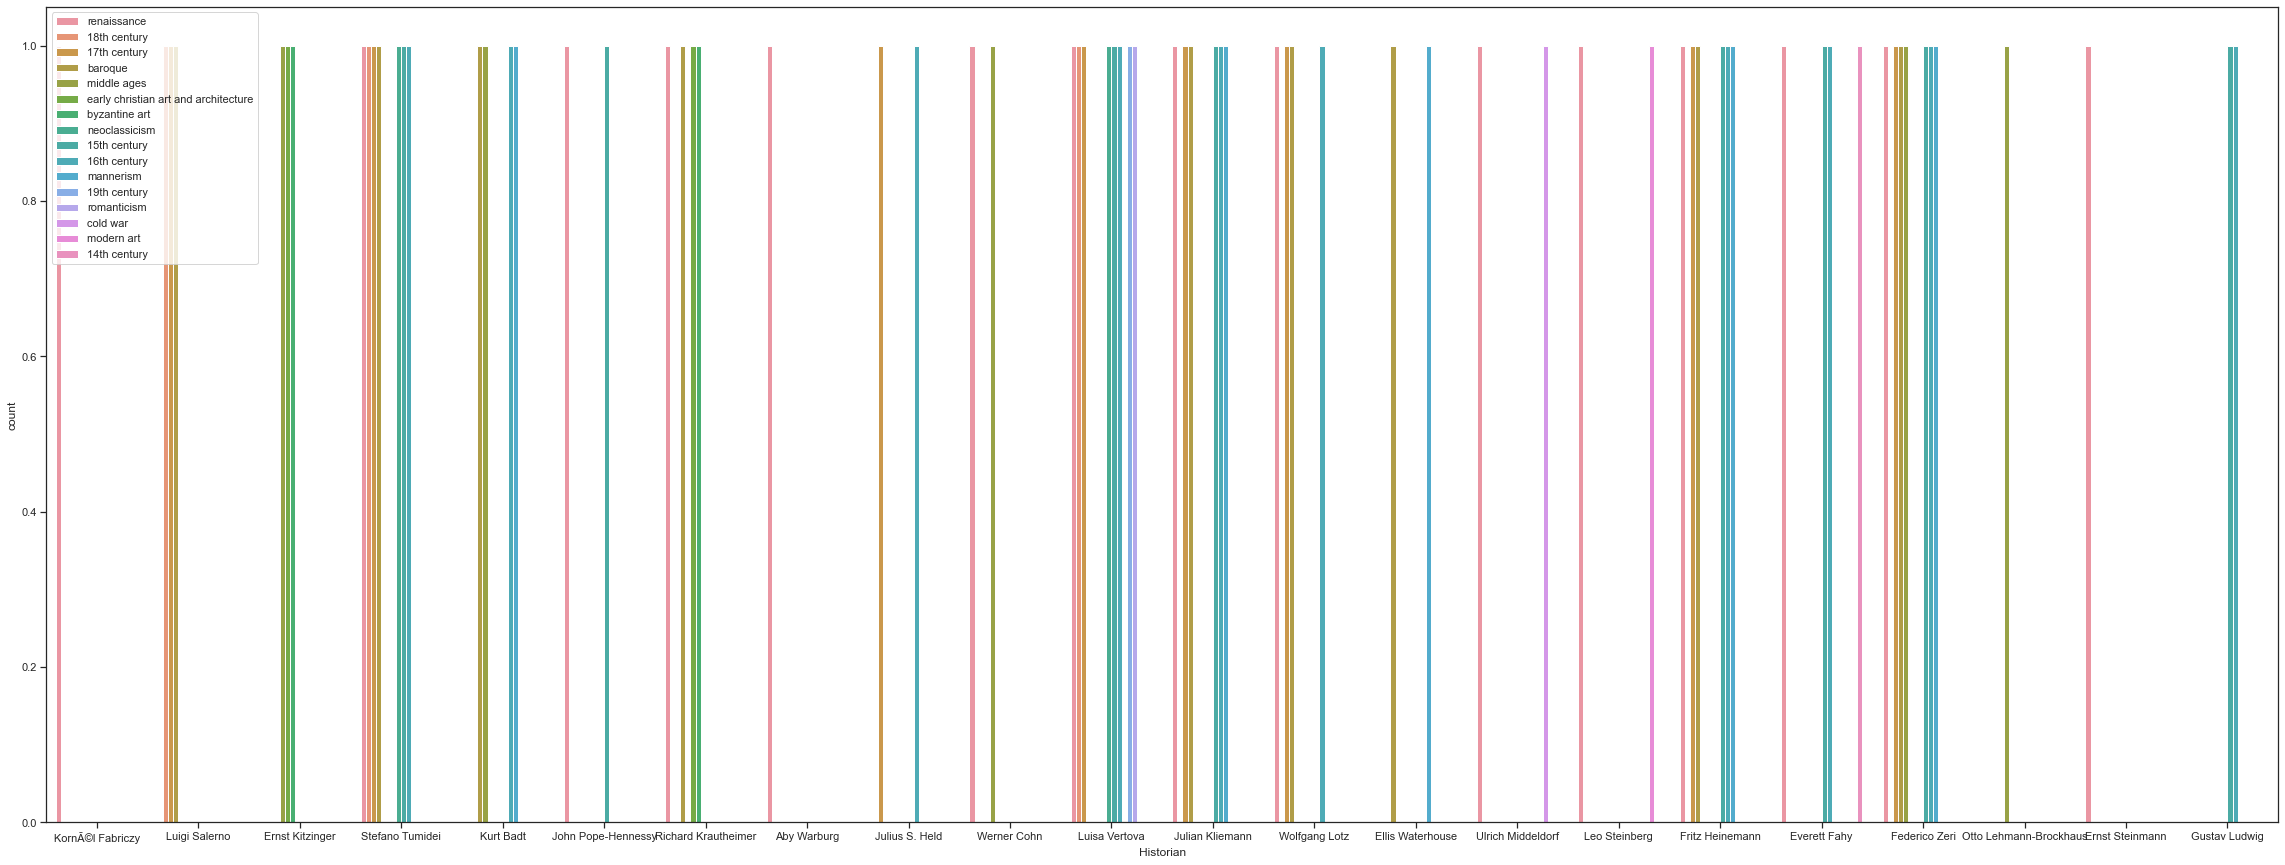

In [68]:
#create a visualization for: PERIODS STUDIED BY EACH HISTORIAN
import seaborn as sns
import matplotlib.pyplot as plt
fig_dims = (40, 15)
fig, ax = plt.subplots(figsize=fig_dims)
ax = sns.countplot(x="Historian", hue="Period", data=df)
plt.legend(loc='upper left')


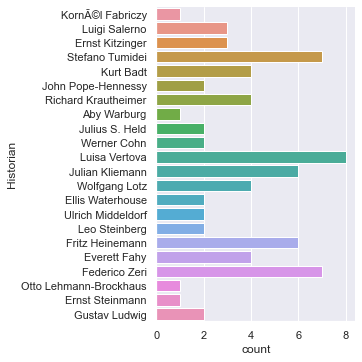

In [69]:
#plot the COUNT OF PERIODS STUDIED BY EACH HISTORIAN
import seaborn as sns
import matplotlib.pyplot as plt


sns.set_theme()
ax = sns.catplot(y="Historian", kind= "count", data= df)

In [89]:
#create a: PIE CHART: NUMBER OF PERIODS STUDIED BY EACH HISTORIAN
from math import pi
import pandas as pd
from bokeh.io import output_file, show, curdoc 
from bokeh.plotting import figure
from bokeh.transform import cumsum
import random

output_file("pie_historian_periods.html")
curdoc().theme = 'dark_minimal'

x ={
     'Ernst Kitzinger':3,
     'Gustav Ludwig':2,
     'Kornél Fabriczy':4,
     'Richard Krautheimer':4, 
     'Ellis Waterhouse':2, 
     'Everett Fahy':4, 
     'Kurt Badt':4, 
     'Luisa Vertova':8, 
     'Luigi Salerno':3, 
     'Julius S. Held':2, 
     'John Pope-Hennessy':2, 
     'Julian Kliemann':6, 
     'Aby Warburg':1, 
     'Werner Cohn':2, 
     'Leo Steinberg':2, 
     'Ernst Steinmann':1, 
     'Stefano Tumidei':7, 
     'Ulrich Middeldorf':2, 
     'Fritz Heinemann':6, 
     'Wolfgang Lotz':4, 
     'Otto Lehmann-Brockhaus':1, 
     'Federico Zeri':7
 }


data = pd.Series(x).reset_index(name='value').rename(columns={'index':'Historians'})
data['angle'] = data['value']/data['value'].sum() * 2*pi
number_of_colors = 22 
palette = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]
data['color'] = palette

p = figure(plot_height=700, title="Number of studied Periods per Historian", toolbar_location=None,
           tools="hover", tooltips="@Historians: @value", x_range=(-0.5, 1.0))

p.wedge(x=0, y=1, radius=0.4,
        start_angle=cumsum('angle', include_zero=True), end_angle=cumsum('angle'),
        line_color="white", fill_color='color', legend_field='Historians', source=data)

p.axis.axis_label=None
p.axis.visible=False
p.grid.grid_line_color = None

show(p)
#included in the website, the matrix used to develope this plot is in the cell immediately below

In [86]:
#create the MATRIX with the number of collection per historian FOR THE PIE CHART COUNT
import csv
from collections import defaultdict
import numpy as np
data = {} # final data
with open('historian_periods_without_dupes.csv') as csvfile:
    historians = [] 
    rows = csv.reader(csvfile, delimiter=',')
    next(rows) # skip the header
    for row in rows:
        if row[0] not in historians:
            historians.append(row[0]) 
       
    print(historians)
    periods_zeros_matrix = np.array(np.zeros((len(historians) ))) 
    
    for i, histo in enumerate(historians):   
            with open('historian_periods_without_dupes.csv') as csvfile:
                rows = csv.reader(csvfile, delimiter=',')
                for row in rows:
                    if row[0] == histo:  
                        periods_zeros_matrix[i] = int(periods_zeros_matrix[i])+1
    
    periods_zeros_matrix
    

print(periods_zeros_matrix)

['Otto Lehmann-Brockhaus', 'Luigi Salerno', 'Ulrich Middeldorf', 'Ellis Waterhouse', 'Stefano Tumidei', 'Richard Krautheimer', 'Ernst Steinmann', 'Ernst Kitzinger', 'Aby Warburg', 'John Pope-Hennessy', 'Julian Kliemann', 'Werner Cohn', 'Luisa Vertova', 'Julius S. Held', 'Everett Fahy', 'Fritz Heinemann', 'Wolfgang Lotz', 'Leo Steinberg', 'KornÃ©l Fabriczy', 'Federico Zeri', 'Gustav Ludwig', 'Kurt Badt']
[1. 3. 2. 2. 7. 4. 1. 3. 1. 2. 6. 2. 8. 2. 4. 6. 4. 2. 1. 7. 2. 4.]


In [70]:
#another matrix for a barchart
import csv
from collections import defaultdict
import numpy as np
data = {} # final data
with open('historian_periods_without_dupes.csv', encoding="utf8") as csvfile:
    historians = [] 
    periods = []
    rows = csv.reader(csvfile, delimiter=',')
    next(rows) # skip the header
    for row in rows:
        if row[0] not in historians:
            historians.append(row[0]) 
        if row[1] not in periods:
            periods.append(row[1]) 
    print(historians)
    print(periods)
    periods.sort()
    periods_zeros_matrix = np.array(np.zeros(( len(periods), len(historians) ))) # rows, columns
    
    for i, histo in enumerate(historians): 
        for j, period in enumerate(periods):
            with open('historian_periods_without_dupes.csv') as csvfile:
                rows = csv.reader(csvfile, delimiter=',')
                for row in rows:
                    if row[1] == period and row[0] == histo:  
                        periods_zeros_matrix[j][i] = int(periods_zeros_matrix[j][i])+1
    
    periods_zeros_matrix
    
# put everything together
data["Historians"] = historians
for i, period in enumerate(periods):
    data[period] = list(periods_zeros_matrix[i])
print(data)

['Kornél Fabriczy', 'Luigi Salerno', 'Ernst Kitzinger', 'Stefano Tumidei', 'Kurt Badt', 'John Pope-Hennessy', 'Richard Krautheimer', 'Aby Warburg', 'Julius S. Held', 'Werner Cohn', 'Luisa Vertova', 'Julian Kliemann', 'Wolfgang Lotz', 'Ellis Waterhouse', 'Ulrich Middeldorf', 'Leo Steinberg', 'Fritz Heinemann', 'Everett Fahy', 'Federico Zeri', 'Otto Lehmann-Brockhaus', 'Ernst Steinmann', 'Gustav Ludwig']
['renaissance', '18th century', '17th century', 'baroque', 'middle ages', 'early christian art and architecture', 'byzantine art', 'neoclassicism', '15th century', '16th century', 'mannerism', '19th century', 'romanticism', 'cold war', 'modern art', '14th century']
{'Historians': ['Kornél Fabriczy', 'Luigi Salerno', 'Ernst Kitzinger', 'Stefano Tumidei', 'Kurt Badt', 'John Pope-Hennessy', 'Richard Krautheimer', 'Aby Warburg', 'Julius S. Held', 'Werner Cohn', 'Luisa Vertova', 'Julian Kliemann', 'Wolfgang Lotz', 'Ellis Waterhouse', 'Ulrich Middeldorf', 'Leo Steinberg', 'Fritz Heinemann', 'E

In [37]:
#BARCHART of Artistic Periods studied by each art historian
from bokeh.io import output_file, show
from bokeh.models import ColumnDataSource, FactorRange
from bokeh.plotting import figure
from bokeh.transform import factor_cmap
from bokeh.layouts import row
import random
#black bar nested colormapped, not particularly clear
output_file("bar_nested_colormapped_period_histo.html")

historians = ['Otto Lehmann-Brockhaus', 'Luigi Salerno', 'Ulrich Middeldorf', 'Ellis Waterhouse', 'Stefano Tumidei', 'Richard Krautheimer', 'Ernst Steinmann', 'Ernst Kitzinger', 'Aby Warburg', 'John Pope-Hennessy', 'Julian Kliemann', 'Werner Cohn', 'Luisa Vertova', 'Julius S. Held', 'Everett Fahy', 'Fritz Heinemann', 'Wolfgang Lotz', 'Leo Steinberg', 'KornÃ©l Fabriczy', 'Federico Zeri', 'Gustav Ludwig', 'Kurt Badt']
periods = ['middle ages', '18th century', 'baroque', '17th century', 'renaissance', 'mannerism', '16th century', '15th century', 'neoclassicism', 'early christian art and architecture', 'byzantine art', 'cold war', '19th century', 'romanticism', '14th century', 'modern art']
data = {'Historians': ['Otto Lehmann-Brockhaus', 'Luigi Salerno', 'Ulrich Middeldorf', 'Ellis Waterhouse', 'Stefano Tumidei', 'Richard Krautheimer', 'Ernst Steinmann', 'Ernst Kitzinger', 'Aby Warburg', 'John Pope-Hennessy', 'Julian Kliemann', 'Werner Cohn', 'Luisa Vertova', 'Julius S. Held', 'Everett Fahy', 'Fritz Heinemann', 'Wolfgang Lotz', 'Leo Steinberg', 'KornÃ©l Fabriczy', 'Federico Zeri', 'Gustav Ludwig', 'Kurt Badt'], '14th century': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], '15th century': [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0], '16th century': [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0], '17th century': [0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0], '18th century': [0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], '19th century': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'baroque': [0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0], 'byzantine art': [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'cold war': [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'early christian art and architecture': [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'mannerism': [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0], 'middle ages': [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0], 'modern art': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], 'neoclassicism': [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'renaissance': [0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0], 'romanticism': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}
number_of_colors = 18 # pick random colors
palette = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]

x = [ (historian, period) for historian in historians for period in periods ]
counts = sum(zip(data['middle ages'], data['18th century'], data['baroque'], data['17th century'], data['renaissance'], data['mannerism'], data['16th century'], data['15th century'], data['neoclassicism'], data['early christian art and architecture'],data['byzantine art'], data['cold war'], data['19th century'], data['romanticism'], data['14th century'], data['modern art'],), ()) # like an hstack

source = ColumnDataSource(data=dict(x=x, counts=counts))

p = figure(x_range=FactorRange(*x), plot_height=650, width=4000, title="Artistic Periods of Interest per Historian",
           toolbar_location=None, tools="")

p.vbar(x='x', top='counts', width=0.9, source=source, line_color="white",
       fill_color=factor_cmap('x', palette=palette, factors=periods, start=1, end=2))

p.unapply_theme()
p.y_range.start = 0
p.x_range.range_padding = 0.1
p.xaxis.major_label_orientation = 1.55
p.xgrid.grid_line_color = None
p.xaxis.major_label_standoff = 30

show(row(p))
#this type of barchart is not user friendly, not so clear


In [36]:
#create another type of BARCHART (not nested) of historians and their studied periods
from bokeh.io import output_file, show
from bokeh.models import ColumnDataSource
from bokeh.palettes import GnBu3, OrRd3
from bokeh.plotting import figure

output_file("bar_stacked_split.html")

historians = ['Otto Lehmann-Brockhaus', 'Luigi Salerno', 'Ulrich Middeldorf', 'Ellis Waterhouse', 'Stefano Tumidei', 'Richard Krautheimer', 'Ernst Steinmann', 'Ernst Kitzinger', 'Aby Warburg', 'John Pope-Hennessy', 'Julian Kliemann', 'Werner Cohn', 'Luisa Vertova', 'Julius S. Held', 'Everett Fahy', 'Fritz Heinemann', 'Wolfgang Lotz', 'Leo Steinberg', 'Kornél Fabriczy', 'Federico Zeri', 'Gustav Ludwig', 'Kurt Badt']
periods = ['middle ages', '18th century', 'baroque', '17th century', 'renaissance', 'mannerism', '16th century', '15th century', 'neoclassicism', 'early christian art and architecture', 'byzantine art', 'cold war', '19th century', 'romanticism', '14th century', 'modern art']

data = {'Historians': ['Otto Lehmann-Brockhaus', 'Luigi Salerno', 'Ulrich Middeldorf', 'Ellis Waterhouse', 'Stefano Tumidei', 'Richard Krautheimer', 'Ernst Steinmann', 'Ernst Kitzinger', 'Aby Warburg', 'John Pope-Hennessy', 'Julian Kliemann', 'Werner Cohn', 'Luisa Vertova', 'Julius S. Held', 'Everett Fahy', 'Fritz Heinemann', 'Wolfgang Lotz', 'Leo Steinberg', 'Kornél Fabriczy', 'Federico Zeri', 'Gustav Ludwig', 'Kurt Badt'], '14th century': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], '15th century': [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0], '16th century': [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0], '17th century': [0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0], '18th century': [0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], '19th century': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'baroque': [0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0], 'byzantine art': [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'cold war': [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'early christian art and architecture': [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'mannerism': [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0], 'middle ages': [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0], 'modern art': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], 'neoclassicism': [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'renaissance': [0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0], 'romanticism': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}
number_of_colors = 16 
palette = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]

p = figure(y_range=historians, plot_width=750, plot_height=750, x_range=(-18, 18), title="Artistic Periods of Interest per Historian",
           toolbar_location=None, tools="hover", tooltips="$name: @$name")

p.hbar_stack(periods, y='Historians', width=0, height=0.9, color=palette, source=ColumnDataSource(data),
             legend_label=["%s" % x for x in periods])

p.unapply_theme()
p.y_range.range_padding = 0.1
p.ygrid.grid_line_color = None
p.legend.location = "top_left"
p.axis.minor_tick_line_color = None
p.outline_line_color = None

show(p)
#included in the website

In [63]:
#create an horizontal dark BARCHART of historians and their studied periods
#just an experiment
from bokeh.io import output_file, show, curdoc
from bokeh.models import ColumnDataSource
from bokeh.palettes import GnBu3, OrRd3
from bokeh.plotting import figure
import random

output_file("blackbar_stacked_split_histo_per.html")
curdoc().theme = "dark_minimal"
historians = ['Otto Lehmann-Brockhaus', 'Luigi Salerno', 'Ulrich Middeldorf', 'Ellis Waterhouse', 'Stefano Tumidei', 'Richard Krautheimer', 'Ernst Steinmann', 'Ernst Kitzinger', 'Aby Warburg', 'John Pope-Hennessy', 'Julian Kliemann', 'Werner Cohn', 'Luisa Vertova', 'Julius S. Held', 'Everett Fahy', 'Fritz Heinemann', 'Wolfgang Lotz', 'Leo Steinberg', 'Kornél Fabriczy', 'Federico Zeri', 'Gustav Ludwig', 'Kurt Badt']
periods = ['middle ages', '18th century', 'baroque', '17th century', 'renaissance', 'mannerism', '16th century', '15th century', 'neoclassicism', 'early christian art and architecture', 'byzantine art', 'cold war', '19th century', 'romanticism', '14th century', 'modern art']

data = {'Historians': ['Otto Lehmann-Brockhaus', 'Luigi Salerno', 'Ulrich Middeldorf', 'Ellis Waterhouse', 'Stefano Tumidei', 'Richard Krautheimer', 'Ernst Steinmann', 'Ernst Kitzinger', 'Aby Warburg', 'John Pope-Hennessy', 'Julian Kliemann', 'Werner Cohn', 'Luisa Vertova', 'Julius S. Held', 'Everett Fahy', 'Fritz Heinemann', 'Wolfgang Lotz', 'Leo Steinberg', 'Kornél Fabriczy', 'Federico Zeri', 'Gustav Ludwig', 'Kurt Badt'], '14th century': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], '15th century': [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0], '16th century': [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0], '17th century': [0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0], '18th century': [0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], '19th century': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'baroque': [0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0], 'byzantine art': [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'cold war': [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'early christian art and architecture': [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'mannerism': [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0], 'middle ages': [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0], 'modern art': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], 'neoclassicism': [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'renaissance': [0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0], 'romanticism': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}
number_of_colors = 16 
palette = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]

p = figure(x_range=historians, plot_height=750, plot_width=3400, title="Artistic Periods of Interest per Historian",
           toolbar_location=None, tools="hover", tooltips="$name: @$name")


p.vbar_stack(periods, x='Historians', width=0.9, color=palette, source=data,
             legend_label=["%s" % x for x in periods]) #horizontal




p.y_range.start = 0
p.x_range.range_padding = 0.1
p.ygrid.grid_line_color = None
p.legend.location = "top_left"
p.yaxis.major_label_standoff= 40
p.axis.minor_tick_line_color = None
p.outline_line_color = None

show(p)
#not clear, not included in the website

Put everything together: see which keeper holds which collection

In [83]:
#RELATE COLLECTIONS TO KEEPERS

import rdflib
from rdflib import Namespace , Literal , URIRef
from rdflib.namespace import RDF , RDFS
import csv


wd = Namespace("http://www.wikidata.org/entity/") 
wdt = Namespace("http://www.wikidata.org/prop/direct/")
art = Namespace("https://w3id.org/artchives/")



g = rdflib.ConjunctiveGraph()



result = g.parse("artchives.nq", format='nquads')

#search the label of the collection and the institute in which it is 
    
query_result = g.query("""
    PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    PREFIX wd: <http://www.wikidata.org/entity/>
    PREFIX wdt: <http://www.wikidata.org/prop/direct/>
    PREFIX art: <https://w3id.org/artchives/>
    SELECT DISTINCT ?Collection ?Keeper
    WHERE {
         ?keep a wd:Q31855 ; 
                 rdfs:label ?Keeper .
        ?collect wdt:P170 ?artHistorian .
        ?collect rdfs:label ?Collection .
        ?artHistorian rdfs:label ?Historian . 
    }
    GROUP BY ?Collection ?Keeper
    """)
#create a csv file
with open('collection_keeper.csv', 'w') as out_file:
    csv_writer = csv.writer(out_file, delimiter=',' , quoting=csv.QUOTE_ALL)
    csv_writer.writerow(['Collection', 'Keeper'])
    for Collection, Keeper in query_result:
        csv_writer.writerow([Collection.strip(), Keeper.strip()])
        
#open the dataframe with pandas        
import pandas as pd
data = pd.read_csv('collection_keeper.csv', encoding = 'latin-1', error_bad_lines=False)

data.head(30)

Collection  \
0                                       Fototeca Zeri   
1                           John Pope-Hennessy papers   
2                     Nachlass Otto Lehmann-Brockhaus   
3                   Venturi Adolfo (complex of fonds)   
4                                Nachlass Werner Cohn   
5                            Fototeca Julian Kliemann   
6                              Archivio Luisa Vertova   
7                          Nachlass Ulrich Middeldorf   
8                       Luigi Salerno research papers   
9                     Nachlass Cornelius von Fabriczy   
10                           Fototeca Stefano Tumidei   
11                       Nachlass Richard Krautheimer   
12                           Nachlass Ernst Steinmann   
13                             Nachlass Wolfgang Lotz   
14                                 Nachlass Kurt Badt   
15                           Ulrich Middledorf papers   
16                      Leo Steinberg research papers   
17                                  Fondo Aby Warburg   
18                          Gustav Ludwig-Vermächtnis   
19                              Julius S. Held papers   
20  Nachlass Fritz Heinemann, Notizen zur venezian...   
21   Ellis K. Waterhouse notebooks and research files   
22                                      Fototeca Fahy   
23                Battisti Eugenio (complex of fonds)   
24                  Ernst Kitzinger papers, 1931-1995   
25                                      Fototeca Zeri   
26                          John Pope-Hennessy papers   
27                    Nachlass Otto Lehmann-Brockhaus   
28                  Venturi Adolfo (complex of fonds)   
29                               Nachlass Werner Cohn   

                      Keeper  
0   Getty Research Institute  
1   Getty Research Institute  
2   Getty Research Institute  
3   Getty Research Institute  
4   Getty Research Institute  
5   Getty Research Institute  
6   Getty Research Institute  
7   Getty Research Institute  
8   Getty Research Institute  
9   Getty Research Institute  
10  Getty Research Institute  
11  Getty Research Institute  
12  Getty Research Institute  
13  Getty Research Institute  
14  Getty Research Institute  
15  Getty Research Institute  
16  Getty Research Institute  
17  Getty Research Institute  
18  Getty Research Institute  
19  Getty Research Institute  
20  Getty Research Institute  
21  Getty Research Institute  
22  Getty Research Institute  
23  Getty Research Institute  
24  Getty Research Institute  
25  Getty Research Institute  
26  Getty Research Institute  
27  Getty Research Institute  
28  Getty Research Institute  
29  Getty Research Institute

In [84]:
import csv
import pandas as pd


with open("collection_keeper.csv") as csv_file:
    df = pd.read_csv(csv_file, delimiter=',', encoding = "latin-1")
print(df.head(20))

                           Collection                    Keeper
0                       Fototeca Zeri  Getty Research Institute
1           John Pope-Hennessy papers  Getty Research Institute
2     Nachlass Otto Lehmann-Brockhaus  Getty Research Institute
3   Venturi Adolfo (complex of fonds)  Getty Research Institute
4                Nachlass Werner Cohn  Getty Research Institute
5            Fototeca Julian Kliemann  Getty Research Institute
6              Archivio Luisa Vertova  Getty Research Institute
7          Nachlass Ulrich Middeldorf  Getty Research Institute
8       Luigi Salerno research papers  Getty Research Institute
9     Nachlass Cornelius von Fabriczy  Getty Research Institute
10           Fototeca Stefano Tumidei  Getty Research Institute
11       Nachlass Richard Krautheimer  Getty Research Institute
12           Nachlass Ernst Steinmann  Getty Research Institute
13             Nachlass Wolfgang Lotz  Getty Research Institute
14                 Nachlass Kurt Badt  G

In [85]:
#delete the duplicates from the file created before
import pandas as pd
file_name = "collection_keeper.csv"
file_name_output = "collection_keeper_periods_without_dupes.csv"

df = pd.read_csv(file_name, sep=",", engine = "python", encoding = 'latin-1')
df.columns = df.columns.str.replace(' ', '')


df.drop_duplicates(subset=None, inplace=True)

# Write the results to a different file
df.to_csv(file_name_output, index=False, sep=",", encoding="utf8")


df = pd.read_csv("collection_keeper_periods_without_dupes.csv", delimiter=',', encoding = "utf8")
df.columns = df.columns.str.replace(' ', '')

df.drop_duplicates('Collection', keep= 'last')
df.drop_duplicates('Keeper', keep= 'last')

df.head(40)

Collection  \
0                                       Fototeca Zeri   
1                           John Pope-Hennessy papers   
2                     Nachlass Otto Lehmann-Brockhaus   
3                   Venturi Adolfo (complex of fonds)   
4                                Nachlass Werner Cohn   
5                            Fototeca Julian Kliemann   
6                              Archivio Luisa Vertova   
7                          Nachlass Ulrich Middeldorf   
8                       Luigi Salerno research papers   
9                     Nachlass Cornelius von Fabriczy   
10                           Fototeca Stefano Tumidei   
11                       Nachlass Richard Krautheimer   
12                           Nachlass Ernst Steinmann   
13                             Nachlass Wolfgang Lotz   
14                                 Nachlass Kurt Badt   
15                           Ulrich Middledorf papers   
16                      Leo Steinberg research papers   
17                                  Fondo Aby Warburg   
18                          Gustav Ludwig-Vermächtnis   
19                              Julius S. Held papers   
20  Nachlass Fritz Heinemann, Notizen zur venezian...   
21   Ellis K. Waterhouse notebooks and research files   
22                                      Fototeca Fahy   
23                Battisti Eugenio (complex of fonds)   
24                  Ernst Kitzinger papers, 1931-1995   
25                                      Fototeca Zeri   
26                          John Pope-Hennessy papers   
27                    Nachlass Otto Lehmann-Brockhaus   
28                  Venturi Adolfo (complex of fonds)   
29                               Nachlass Werner Cohn   
30                           Fototeca Julian Kliemann   
31                             Archivio Luisa Vertova   
32                         Nachlass Ulrich Middeldorf   
33                      Luigi Salerno research papers   
34                    Nachlass Cornelius von Fabriczy   
35                           Fototeca Stefano Tumidei   
36                       Nachlass Richard Krautheimer   
37                           Nachlass Ernst Steinmann   
38                             Nachlass Wolfgang Lotz   
39                                 Nachlass Kurt Badt   

                      Keeper  
0   Getty Research Institute  
1   Getty Research Institute  
2   Getty Research Institute  
3   Getty Research Institute  
4   Getty Research Institute  
5   Getty Research Institute  
6   Getty Research Institute  
7   Getty Research Institute  
8   Getty Research Institute  
9   Getty Research Institute  
10  Getty Research Institute  
11  Getty Research Institute  
12  Getty Research Institute  
13  Getty Research Institute  
14  Getty Research Institute  
15  Getty Research Institute  
16  Getty Research Institute  
17  Getty Research Institute  
18  Getty Research Institute  
19  Getty Research Institute  
20  Getty Research Institute  
21  Getty Research Institute  
22  Getty Research Institute  
23  Getty Research Institute  
24  Getty Research Institute  
25  Scuola Normale Superiore  
26  Scuola Normale Superiore  
27  Scuola Normale Superiore  
28  Scuola Normale Superiore  
29  Scuola Normale Superiore  
30  Scuola Normale Superiore  
31  Scuola Normale Superiore  
32  Scuola Normale Superiore  
33  Scuola Normale Superiore  
34  Scuola Normale Superiore  
35  Scuola Normale Superiore  
36  Scuola Normale Superiore  
37  Scuola Normale Superiore  
38  Scuola Normale Superiore  
39  Scuola Normale Superiore

In [86]:
import pandas_profiling as pp
pp.ProfileReport(df.drop_duplicates('Collection', keep= 'last'))
pp.ProfileReport(df.drop_duplicates('Keeper', keep= 'last'))

Summarize dataset:   0%|          | 0/16 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

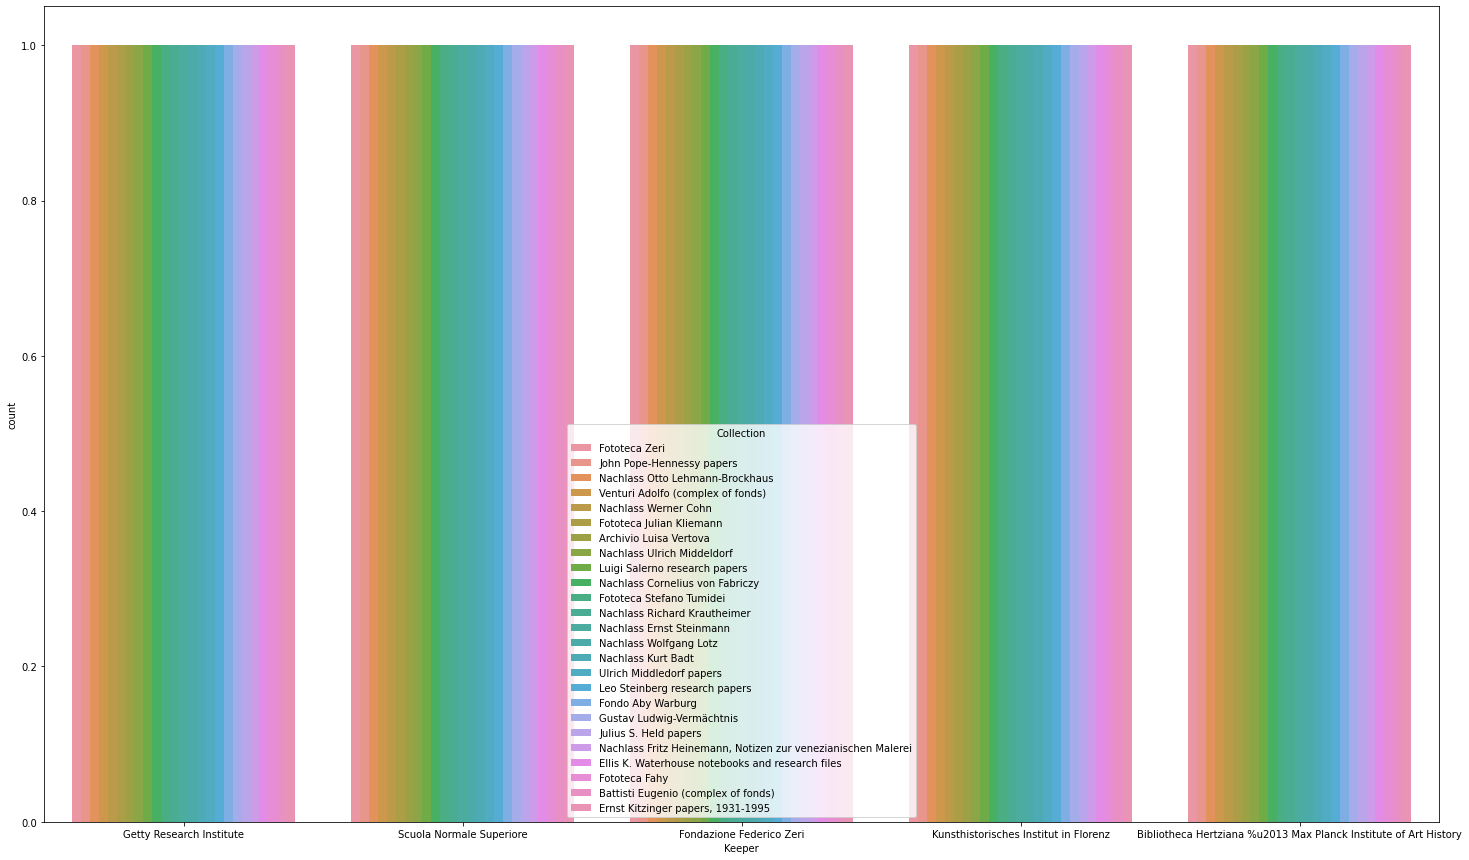

In [87]:
# the visualization shows that ALL the five keepers have ALL the collections
import seaborn as sns
import matplotlib.pyplot as plt
fig_dims = (25, 15)
fig, ax = plt.subplots(figsize=fig_dims)
ax = sns.countplot(x="Keeper", hue="Collection", data=df) 

C:\Users\giulm\lib\site-packages\seaborn\axisgrid.py:64: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout(*args, **kwargs)


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Getty Research Institute'),
  Text(1, 0, 'Scuola Normale Superiore'),
  Text(2, 0, 'Fondazione Federico Zeri'),
  Text(3, 0, 'Kunsthistorisches Institut in Florenz'),
  Text(4, 0, 'Bibliotheca Hertziana %u2013 Max Planck Institute of Art History')])

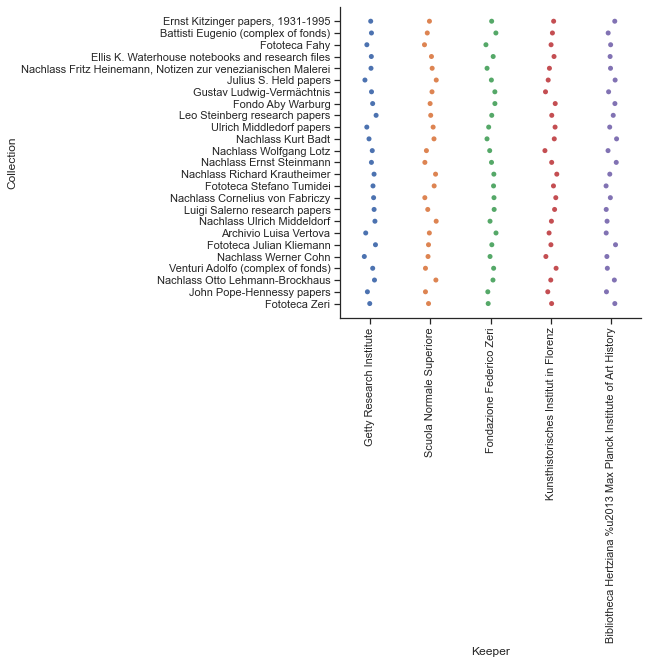

In [88]:
#catplot of collections and keepers
import seaborn as sns
import matplotlib.pyplot as plt


sns.set_theme(style="ticks")

g = sns.catplot(x="Keeper", y="Collection", data=df)
plt.xticks(rotation=90)
#included in the website

In [149]:
#the collections can be found in ALL the institutes
from bokeh.io import output_file, show
from bokeh.models import ColumnDataSource, FactorRange
from bokeh.plotting import figure
from bokeh.transform import factor_cmap
import random

output_file("bar_nested_colormapped_coll_keep.html")

periods = ['Battisti Eugenio (complex of fonds)', 'Julius S. Held papers', 'Leo Steinberg research papers', 'Nachlass Otto Lehmann-Brockhaus', 'Nachlass Cornelius von Fabriczy', 'Fototeca Stefano Tumidei', 'Fototeca Fahy', 'John Pope-Hennessy papers', 'Ellis K. Waterhouse notebooks and research files', 'Gustav Ludwig-Vermächtnis', 'Nachlass Werner Cohn', 'Nachlass Ulrich Middeldorf', 'Nachlass Wolfgang Lotz', 'Fototeca Zeri', 'Fondo Aby Warburg', 'Fototeca Julian Kliemann', 'Nachlass Richard Krautheimer', 'Nachlass Ernst Steinmann', 'Nachlass Kurt Badt', 'Venturi Adolfo (complex of fonds)', 'Ulrich Middledorf papers', 'Luigi Salerno research papers', 'Archivio Luisa Vertova', 'Ernst Kitzinger papers, 1931-1995', 'Nachlass Fritz Heinemann, Notizen zur venezianischen Malerei']
historians = ['Getty Research Institute', 'Scuola Normale Superiore', 'Kunsthistorisches Institut in Florenz', 'Bibliotheca Hertziana %u2013 Max Planck Institute of Art History', 'Fondazione Federico Zeri']
data = {'Historians': ['Ernst Kitzinger papers, 1931-1995', 'Nachlass Werner Cohn', 'Fototeca Fahy', 'Nachlass Cornelius von Fabriczy', 'Archivio Luisa Vertova', 'Nachlass Wolfgang Lotz', 'Ellis K. Waterhouse notebooks and research files', 'Fondo Aby Warburg', 'Nachlass Richard Krautheimer', 'Nachlass Ulrich Middeldorf', 'Fototeca Julian Kliemann', 'Gustav Ludwig-Vermächtnis', 'Leo Steinberg research papers', 'Fototeca Zeri', 'Battisti Eugenio (complex of fonds)', 'Nachlass Kurt Badt', 'Nachlass Fritz Heinemann, Notizen zur venezianischen Malerei', 'Nachlass Ernst Steinmann', 'Ulrich Middledorf papers', 'Fototeca Stefano Tumidei', 'Julius S. Held papers', 'John Pope-Hennessy papers', 'Luigi Salerno research papers', 'Venturi Adolfo (complex of fonds)', 'Nachlass Otto Lehmann-Brockhaus'], 'Bibliotheca Hertziana %u2013 Max Planck Institute of Art History': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'Fondazione Federico Zeri': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'Getty Research Institute': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'Kunsthistorisches Institut in Florenz': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'Scuola Normale Superiore': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]}
number_of_colors = 40 
palette = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]


x = [ (historian, period) for historian in historians for period in periods ]
counts = sum(zip(data['Getty Research Institute'], data['Scuola Normale Superiore'], data['Kunsthistorisches Institut in Florenz'], data['Bibliotheca Hertziana %u2013 Max Planck Institute of Art History'], data['Fondazione Federico Zeri']), ()) # like an hstack

source = ColumnDataSource(data=dict(x=x, counts=counts))

p = figure(x_range=FactorRange(*x), plot_height=650, width=7000, title="Number of Collections per Keeper",
           toolbar_location=None, tools="")

p.vbar(x='x', top='counts', width=0.9, source=source, line_color="white",
       fill_color=factor_cmap('x', palette=palette, factors=periods, start=1, end=2))

p.y_range.start = 0
p.x_range.range_padding = 0.1
p.xaxis.major_label_orientation = 1.55
p.xaxis.major_label_standoff = 70
p.xgrid.grid_line_color = None

show(p) #this is not so user friendly, not included in the website, the catplot plotted with seaborn was preferred. 

Now, we want to find out which period is included in which collection. 

In [1]:
#analyze relations between collections and periods

import rdflib
from rdflib import Namespace , Literal , URIRef
from rdflib.namespace import RDF , RDFS
import csv


wd = Namespace("http://www.wikidata.org/entity/") 
wdt = Namespace("http://www.wikidata.org/prop/direct/")
art = Namespace("https://w3id.org/artchives/")



g = rdflib.ConjunctiveGraph()



result = g.parse("artchives.nq", format='nquads')

#search the label of collections and the artistic periods inside the collections
    
query_result = g.query("""
    PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    PREFIX wd: <http://www.wikidata.org/entity/>
    PREFIX wdt: <http://www.wikidata.org/prop/direct/>
    PREFIX art: <https://w3id.org/artchives/>
    SELECT DISTINCT ?Collection ?Period
    WHERE {
        ?collect wdt:P170 ?artHistorian ;
                 rdfs:label ?Collection ;
                 art:hasSubjectPeriod ?per .
        ?per rdfs:label ?Period
    }
    GROUP BY ?Collection ?Period
    """)

with open('coll_periodo.csv', 'w') as out_file:
    csv_writer = csv.writer(out_file, delimiter=',' , quoting=csv.QUOTE_ALL)
    csv_writer.writerow(['Collection', 'Period'])
    for Collection, Period in query_result:
        csv_writer.writerow([Collection.strip(), Period.lower().strip()]) 
        
import pandas as pd
data = pd.read_csv('coll_periodo.csv', encoding = 'latin-1', error_bad_lines=False)

data.head(30)

Collection        Period
0          Fototeca Julian Kliemann   renaissance
1          Fototeca Julian Kliemann   renaissance
2          Fototeca Julian Kliemann   renaissance
3          Fototeca Julian Kliemann   renaissance
4          Fototeca Julian Kliemann   renaissance
5          Fototeca Julian Kliemann   renaissance
6          Fototeca Julian Kliemann   renaissance
7          Fototeca Julian Kliemann   renaissance
8          Fototeca Julian Kliemann   renaissance
9          Fototeca Julian Kliemann   renaissance
10         Fototeca Julian Kliemann   renaissance
11         Fototeca Stefano Tumidei       baroque
12         Fototeca Stefano Tumidei       baroque
13         Fototeca Stefano Tumidei       baroque
14         Fototeca Stefano Tumidei       baroque
15         Fototeca Stefano Tumidei       baroque
16         Fototeca Stefano Tumidei       baroque
17         Fototeca Stefano Tumidei       baroque
18         Fototeca Stefano Tumidei       baroque
19         Fototeca Stefano Tumidei       baroque
20         Fototeca Stefano Tumidei       baroque
21         Fototeca Stefano Tumidei       baroque
22  Nachlass Otto Lehmann-Brockhaus   middle ages
23  Nachlass Otto Lehmann-Brockhaus   middle ages
24  Nachlass Otto Lehmann-Brockhaus   middle ages
25  Nachlass Otto Lehmann-Brockhaus   middle ages
26  Nachlass Otto Lehmann-Brockhaus   middle ages
27  Nachlass Otto Lehmann-Brockhaus   middle ages
28                    Fototeca Zeri  15th century
29                    Fototeca Zeri  15th century

In [2]:
#delete the duplicates from the file created before
import pandas as pd
file_name = "coll_periodo.csv"
file_name_output = "coll_periodo_no_dupes.csv"

df = pd.read_csv(file_name, sep=",", engine = "python", encoding = 'latin-1')
df.columns = df.columns.str.replace(' ', '')
#delete the duplicates creating a new file: periods and collections without duplicates

df.drop_duplicates(subset=None, inplace=True)

# Write the results to a different file
df.to_csv(file_name_output, index=False, sep=",", encoding="utf8")

In [3]:
df = pd.read_csv("coll_periodo_no_dupes.csv", delimiter=',', encoding = "utf8")
df.columns = df.columns.str.replace(' ', '')
    
df.drop_duplicates("Collection", keep= "last")
df.drop_duplicates("Period", keep="last")



df.head(80)

Collection        Period
0                            Fototeca Julian Kliemann   renaissance
1                            Fototeca Stefano Tumidei       baroque
2                     Nachlass Otto Lehmann-Brockhaus   middle ages
3                                       Fototeca Zeri  15th century
4   Nachlass Fritz Heinemann, Notizen zur venezian...   renaissance
..                                                ...           ...
69  Nachlass Fritz Heinemann, Notizen zur venezian...       baroque
70                    Nachlass Cornelius von Fabriczy   renaissance
71                             Nachlass Wolfgang Lotz  17th century
72                           Fototeca Julian Kliemann  16th century
73                          John Pope-Hennessy papers   renaissance

[74 rows x 2 columns]

In [4]:
import pandas_profiling as pp
pp.ProfileReport(df.drop_duplicates('Collection', keep= 'last'))
pp.ProfileReport(df.drop_duplicates('Period', keep= 'last'))

Summarize dataset:   0%|          | 0/16 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 [Text(0, 0, 'renaissance'),
  Text(1, 0, 'baroque'),
  Text(2, 0, 'middle ages'),
  Text(3, 0, '15th century'),
  Text(4, 0, '18th century'),
  Text(5, 0, '17th century'),
  Text(6, 0, 'modern art'),
  Text(7, 0, '16th century'),
  Text(8, 0, 'mannerism'),
  Text(9, 0, 'byzantine art'),
  Text(10, 0, 'romanticism'),
  Text(11, 0, '19th century'),
  Text(12, 0, 'neoclassicism'),
  Text(13, 0, 'cold war'),
  Text(14, 0, '14th century'),
  Text(15, 0, 'early christian art and architecture')])

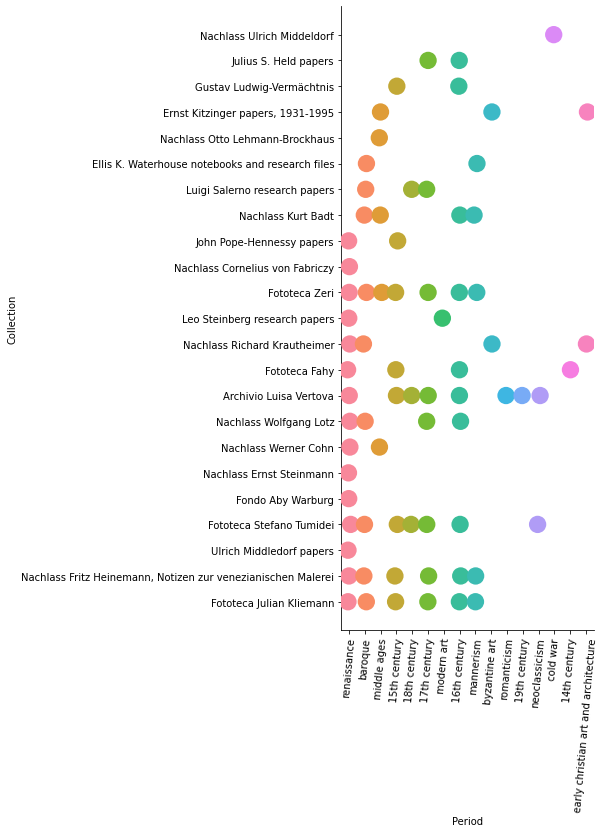

In [5]:
#visualization of collections and periods inside them
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.catplot(x="Period", y="Collection", sizes=(300, 300),data=df, height=9.2)
plt.xticks(rotation=85)

In [6]:
#collections and related period matrix
import csv
from collections import defaultdict
import numpy as np
data = {} # final data
with open('coll_periodo_no_dupes.csv') as csvfile:
    collections = [] 
    periods = []
    rows = csv.reader(csvfile, delimiter=',')
    next(rows) 
    for row in rows:
        if row[0] not in collections:
            collections.append(row[0]) 
        if row[1] not in periods:
            periods.append(row[1]) 
    print(collections)
    print(periods)
    periods.sort()
    periods_zeros_matrix = np.array(np.zeros(( len(periods), len(collections) ))) 
    
    for i, coll in enumerate(collections): 
        for j, period in enumerate(periods):
            with open('coll_periodo_no_dupes.csv') as csvfile:
                rows = csv.reader(csvfile, delimiter=',')
                for row in rows:
                    if row[1] == period and row[0] == coll:  
                        periods_zeros_matrix[j][i] = int(periods_zeros_matrix[j][i])+1
    
    periods_zeros_matrix
    
# put everything together
data["Collection"] = collections
for i, period in enumerate(periods):
    data[period] = list(periods_zeros_matrix[i])
print(data)

['Fototeca Julian Kliemann', 'Fototeca Stefano Tumidei', 'Nachlass Otto Lehmann-Brockhaus', 'Fototeca Zeri', 'Nachlass Fritz Heinemann, Notizen zur venezianischen Malerei', 'Nachlass Wolfgang Lotz', 'John Pope-Hennessy papers', 'Ulrich Middledorf papers', 'Archivio Luisa Vertova', 'Leo Steinberg research papers', 'Luigi Salerno research papers', 'Nachlass Kurt Badt', 'Fondo Aby Warburg', 'Fototeca Fahy', 'Nachlass Ernst Steinmann', 'Ernst Kitzinger papers, 1931-1995', 'Ellis K. Waterhouse notebooks and research files', 'Nachlass Werner Cohn', 'Gustav Ludwig-VermÃ¤chtnis', 'Julius S. Held papers', 'Nachlass Richard Krautheimer', 'Nachlass Ulrich Middeldorf', 'Nachlass Cornelius von Fabriczy']
['renaissance', 'baroque', 'middle ages', '15th century', '18th century', '17th century', 'modern art', '16th century', 'mannerism', 'byzantine art', 'romanticism', '19th century', 'neoclassicism', 'cold war', '14th century', 'early christian art and architecture']
{'Collection': ['Fototeca Julian 

In [46]:
#plot the artistic periods curated in the correspondent collection
from bokeh.io import output_file, show, curdoc
from bokeh.models import ColumnDataSource
from bokeh.palettes import GnBu3, OrRd3
from bokeh.plotting import figure
import random

output_file("bar_coll_periods.html")
curdoc().theme = "dark_minimal" 
collections = ['Luigi Salerno research papers', 'Archivio Luisa Vertova', 'Ellis K. Waterhouse notebooks and research files', 'Fototeca Zeri', 'Julius S. Held papers', 'Gustav Ludwig-Vermächtnis', 'Fototeca Fahy', 'Nachlass Werner Cohn', 'Nachlass Richard Krautheimer', 'Fondo Aby Warburg', 'Nachlass Fritz Heinemann, Notizen zur venezianischen Malerei', 'Nachlass Kurt Badt', 'John Pope-Hennessy papers', 'Fototeca Stefano Tumidei', 'Nachlass Ulrich Middeldorf', 'Ernst Kitzinger papers, 1931-1995', 'Leo Steinberg research papers', 'Nachlass Ernst Steinmann', 'Nachlass Wolfgang Lotz', 'Fototeca Julian Kliemann', 'Nachlass Cornelius von Fabriczy', 'Ulrich Middledorf papers', 'Nachlass Otto Lehmann-Brockhaus']
periods = ['17th century', 'romanticism', 'baroque', 'middle ages', '16th century', 'renaissance', '15th century', 'mannerism', 'neoclassicism', 'early christian art and architecture', '18th century', 'cold war', 'modern art', '19th century', 'byzantine art', '14th century']
data = {'Collection': ['Luigi Salerno research papers', 'Archivio Luisa Vertova', 'Ellis K. Waterhouse notebooks and research files', 'Fototeca Zeri', 'Julius S. Held papers', 'Gustav Ludwig-Vermächtnis', 'Fototeca Fahy', 'Nachlass Werner Cohn', 'Nachlass Richard Krautheimer', 'Fondo Aby Warburg', 'Nachlass Fritz Heinemann, Notizen zur venezianischen Malerei', 'Nachlass Kurt Badt', 'John Pope-Hennessy papers', 'Fototeca Stefano Tumidei', 'Nachlass Ulrich Middeldorf', 'Ernst Kitzinger papers, 1931-1995', 'Leo Steinberg research papers', 'Nachlass Ernst Steinmann', 'Nachlass Wolfgang Lotz', 'Fototeca Julian Kliemann', 'Nachlass Cornelius von Fabriczy', 'Ulrich Middledorf papers', 'Nachlass Otto Lehmann-Brockhaus'], '14th century': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], '15th century': [0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0], '16th century': [0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0], '17th century': [1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0], '18th century': [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], '19th century': [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'baroque': [1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0], 'byzantine art': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'cold war': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'early christian art and architecture': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'mannerism': [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0], 'middle ages': [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], 'modern art': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'neoclassicism': [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'renaissance': [0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0], 'romanticism': [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}
number_of_colors = 16 
palette = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]

p = figure(x_range=collections, plot_height=750, plot_width=7300, title="Artistic Periods inside each Collection",
           toolbar_location=None, tools="hover", tooltips="$name: @$name")


p.vbar_stack(periods, x='Collection', width=0.9, color=palette, source=data,
             legend_label=["%s" % x for x in periods])




p.y_range.start = 0
p.x_range.range_padding = 0.1
p.ygrid.grid_line_color = None
p.legend.location = "top_left"
p.yaxis.major_label_standoff= 40
p.axis.minor_tick_line_color = None
p.outline_line_color = None

show(p) #this is dark, not a nice layout, not included

In [40]:
#create a BARCHART of collections and their periods
from bokeh.io import output_file, show
from bokeh.models import ColumnDataSource
from bokeh.palettes import GnBu3, OrRd3
from bokeh.plotting import figure

output_file("bar_stacked_split_coll_periods.html")
#period studied by historians
collections = ['Luigi Salerno research papers', 'Archivio Luisa Vertova', 'Ellis K. Waterhouse notebooks and research files', 'Fototeca Zeri', 'Julius S. Held papers', 'Gustav Ludwig-Vermächtnis', 'Fototeca Fahy', 'Nachlass Werner Cohn', 'Nachlass Richard Krautheimer', 'Fondo Aby Warburg', 'Nachlass Fritz Heinemann, Notizen zur venezianischen Malerei', 'Nachlass Kurt Badt', 'John Pope-Hennessy papers', 'Fototeca Stefano Tumidei', 'Nachlass Ulrich Middeldorf', 'Ernst Kitzinger papers, 1931-1995', 'Leo Steinberg research papers', 'Nachlass Ernst Steinmann', 'Nachlass Wolfgang Lotz', 'Fototeca Julian Kliemann', 'Nachlass Cornelius von Fabriczy', 'Ulrich Middledorf papers', 'Nachlass Otto Lehmann-Brockhaus']
periods = ['17th century', 'romanticism', 'baroque', 'middle ages', '16th century', 'renaissance', '15th century', 'mannerism', 'neoclassicism', 'early christian art and architecture', '18th century', 'cold war', 'modern art', '19th century', 'byzantine art', '14th century']
data = {'Collection': ['Luigi Salerno research papers', 'Archivio Luisa Vertova', 'Ellis K. Waterhouse notebooks and research files', 'Fototeca Zeri', 'Julius S. Held papers', 'Gustav Ludwig-Vermächtnis', 'Fototeca Fahy', 'Nachlass Werner Cohn', 'Nachlass Richard Krautheimer', 'Fondo Aby Warburg', 'Nachlass Fritz Heinemann, Notizen zur venezianischen Malerei', 'Nachlass Kurt Badt', 'John Pope-Hennessy papers', 'Fototeca Stefano Tumidei', 'Nachlass Ulrich Middeldorf', 'Ernst Kitzinger papers, 1931-1995', 'Leo Steinberg research papers', 'Nachlass Ernst Steinmann', 'Nachlass Wolfgang Lotz', 'Fototeca Julian Kliemann', 'Nachlass Cornelius von Fabriczy', 'Ulrich Middledorf papers', 'Nachlass Otto Lehmann-Brockhaus'], '14th century': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], '15th century': [0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0], '16th century': [0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0], '17th century': [1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0], '18th century': [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], '19th century': [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'baroque': [1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0], 'byzantine art': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'cold war': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'early christian art and architecture': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'mannerism': [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0], 'middle ages': [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], 'modern art': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'neoclassicism': [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'renaissance': [0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0], 'romanticism': [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}
number_of_colors = 16 # pick random colors
palette = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]

p = figure(y_range=collections, plot_width=1000, plot_height=750, x_range=(-18, 18), title="Artistic Periods inside each Collection",
           toolbar_location=None, tools="hover", tooltips="$name: @$name")

p.hbar_stack(periods, y='Collection', width=0, height=0.9, color=palette, source=ColumnDataSource(data),
             legend_label=["%s" % x for x in periods])

p.unapply_theme()
p.y_range.range_padding = 0.1
p.ygrid.grid_line_color = None
p.legend.location = "top_left"
p.axis.minor_tick_line_color = None
p.outline_line_color = None

show(p) #nicer layout, included in the website

Final step: query and plot the relation between a keeper and the period treated in the correspondent collection stored in it

In [116]:
#search artistic periods studied in each institute
import rdflib
import csv
from rdflib import Namespace , Literal , URIRef
from rdflib.namespace import RDF , RDFS
import pprint


wd = Namespace("http://www.wikidata.org/entity/") 
wdt = Namespace("http://www.wikidata.org/prop/direct/")
art = Namespace("https://w3id.org/artchives/")


g = rdflib.ConjunctiveGraph()


result = g.parse("artchives.nq", format='nquads')

#search the label of artistic periods studied in each institute and label of institutes
query_keepers = g.query('''
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX wdp: <http://www.wikidata.org/wiki/Property:>
PREFIX art: <https://w3id.org/artchives/>
PREFIX wd: <http://www.wikidata.org/entity/>
SELECT DISTINCT  ?Period ?Keeper
WHERE {
 ?keep a wd:Q31855 ; 
         rdfs:label ?Keeper ; 
         wdt:P17 ?country .
 ?coll art:hasSubjectPeriod ?peri .
 ?country rdfs:label ?nameCountry .
 ?peri rdfs:label ?Period . 
}
GROUP BY  ?Period ?Keeper 
''') 


with open('keepers.csv', 'wt') as out_file:
    csv_writer = csv.writer(out_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_ALL)
    csv_writer.writerow(["Period", "Keeper"])
    # access the rows of the query results
    for Period, Keeper in query_keepers:
        # write in the csv
        csv_writer.writerow([Period.lower().strip(), Keeper.strip()])        

        
import pandas as pd
data = pd.read_csv('keepers.csv', encoding = 'Latin-1')

data.head(20)

Period                    Keeper
0    renaissance  Getty Research Institute
1    renaissance  Getty Research Institute
2    renaissance  Getty Research Institute
3    renaissance  Getty Research Institute
4    renaissance  Getty Research Institute
5    renaissance  Getty Research Institute
6    renaissance  Getty Research Institute
7    renaissance  Getty Research Institute
8    renaissance  Getty Research Institute
9    renaissance  Getty Research Institute
10   renaissance  Getty Research Institute
11  15th century  Getty Research Institute
12  15th century  Getty Research Institute
13  15th century  Getty Research Institute
14  15th century  Getty Research Institute
15  15th century  Getty Research Institute
16  15th century  Getty Research Institute
17  15th century  Getty Research Institute
18  17th century  Getty Research Institute
19  17th century  Getty Research Institute

In [117]:
import pandas as pd
file_name = "keepers.csv"
file_name_output = "kep_per_without_dupes.csv"

df = pd.read_csv(file_name, sep=",", engine = "python", encoding = 'latin-1')
df.columns = df.columns.str.replace(' ', '')


df.drop_duplicates(subset=None, inplace=True)

# Write the results to a different file
df.to_csv(file_name_output, index=False, sep=",", encoding="utf8")


df = pd.read_csv("kep_per_without_dupes.csv", delimiter=',', encoding = "latin-1")
df.columns = df.columns.str.replace(' ', '')
   
df.drop_duplicates('Period', keep= 'last')
df.drop_duplicates('Keeper', keep= 'last')

df.head(40)

Period                    Keeper
0                            renaissance  Getty Research Institute
1                           15th century  Getty Research Institute
2                           17th century  Getty Research Institute
3                              mannerism  Getty Research Institute
4                                baroque  Getty Research Institute
5                             modern art  Getty Research Institute
6                           16th century  Getty Research Institute
7                          byzantine art  Getty Research Institute
8                          neoclassicism  Getty Research Institute
9                           18th century  Getty Research Institute
10                           middle ages  Getty Research Institute
11                          19th century  Getty Research Institute
12  early christian art and architecture  Getty Research Institute
13                              cold war  Getty Research Institute
14                          14th century  Getty Research Institute
15                           romanticism  Getty Research Institute
16                           renaissance  Scuola Normale Superiore
17                          15th century  Scuola Normale Superiore
18                          17th century  Scuola Normale Superiore
19                             mannerism  Scuola Normale Superiore
20                               baroque  Scuola Normale Superiore
21                            modern art  Scuola Normale Superiore
22                          16th century  Scuola Normale Superiore
23                         byzantine art  Scuola Normale Superiore
24                         neoclassicism  Scuola Normale Superiore
25                          18th century  Scuola Normale Superiore
26                           middle ages  Scuola Normale Superiore
27                          19th century  Scuola Normale Superiore
28  early christian art and architecture  Scuola Normale Superiore
29                              cold war  Scuola Normale Superiore
30                          14th century  Scuola Normale Superiore
31                           romanticism  Scuola Normale Superiore
32                           renaissance  Fondazione Federico Zeri
33                          15th century  Fondazione Federico Zeri
34                          17th century  Fondazione Federico Zeri
35                             mannerism  Fondazione Federico Zeri
36                               baroque  Fondazione Federico Zeri
37                            modern art  Fondazione Federico Zeri
38                          16th century  Fondazione Federico Zeri
39                         byzantine art  Fondazione Federico Zeri

In [118]:

import pandas_profiling as pp

pp.ProfileReport(df.drop_duplicates('Period', keep= 'last'))

pp.ProfileReport(df.drop_duplicates('Keeper', keep= 'last'))

Summarize dataset:   0%|          | 0/16 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

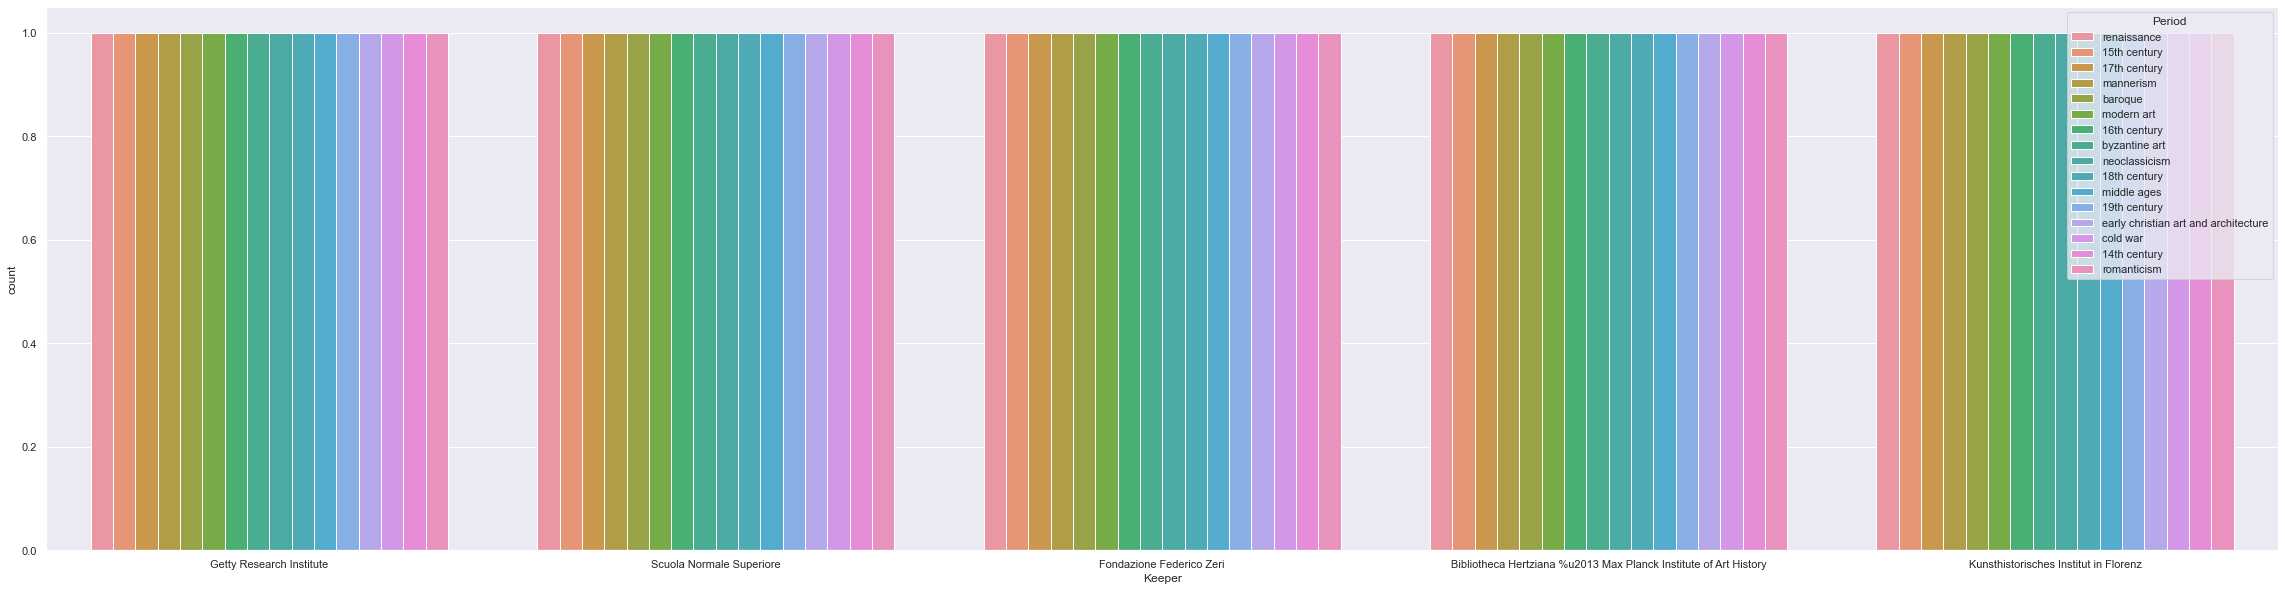

In [121]:
#visualization of periods in each institute
import seaborn as sns
import matplotlib.pyplot as plt
fig_dims = (40, 10)
fig, ax = plt.subplots(figsize=fig_dims)
ax = sns.countplot(x="Keeper", hue="Period", data=df)


All of the given artistic periods are studied in every institute! That's because all the institutes contain all of the collections. 

## FINAL CONSIDERATIONS

- In the process of choosing the artistic period to study, birthplaces and countries of citizeships are not relevant for art historians
-The relevant factor is the location of the institutes, keepers of artistic collections that deals with several artistic periods, or the country of origin of the artistic period itself. 
-The majority of institutes are in fact in Italy, and the most studied period is Renaissance (present in all the collections, kept by all of the institutes), heavily related to italian cultural heritage. 
- Despite their countries of origin or citizenship, many art historians decide to enrich the collections kept by the institutes, mainly located in Italy and in U.S.A. 